In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0+cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 27.6 MB/s eta 0:00:00


In [2]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import matplotlib.pyplot as plt
import torch
from torch_geometric.datasets import TUDataset
import numpy as np
from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from sklearn import metrics
from copy import deepcopy
#from captum.attr import Saliency
from scipy.spatial.distance import hamming
from itertools import zip_longest
from time import perf_counter
import csv
import torch.nn as nn
import torch_geometric.nn as gnn
from torch import Tensor
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from typing import Callable, Union, Tuple
from torch_sparse import SparseTensor
from time import perf_counter
import random
import pandas

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Explainability_name = 'GuidedBP'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [5]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...



Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [6]:
torch.manual_seed(123456)
#dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [6]:
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
  read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
  read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]


In [7]:
torch.manual_seed(123456)
#dataset = dataset.shuffle()

#train_dataset = dataset[:150]
#test_dataset = dataset[150:]
train_dataset = []
test_dataset = []
for index in read_training_list_indexes:
  train_dataset.append(dataset[index])
for index in read_test_list_indexes:
  test_dataset.append(dataset[index])


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


# **Batching Data by DataLoader**

In [8]:
from torch_geometric.loader import DataLoader

BATCH_SIZE = 64
size_of_hidden_layers = 10

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# **Model Designing**

In [ ]:
#class GCN(torch.nn.Module):
#    def __init__(self, hidden_channels):
#        super(GCN, self).__init__()
#        torch.manual_seed(12345)
#        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
#        self.conv2 = GCNConv(hidden_channels, hidden_channels)
#        #self.conv3 = GCNConv(hidden_channels, hidden_channels)
#        self.lin = Linear(hidden_channels, dataset.num_classes)
#
#    def forward(self, x, edge_index, batch):
#        # 1. Obtain node embeddings 
#        x = self.conv1(x, edge_index)
#        x = torch.nn.functional.elu(x)
#
#        x = self.conv2(x, edge_index)
#        x = torch.nn.functional.elu(x)
#
#        #x = self.conv3(x, edge_index)
#        #x = torch.nn.functional.elu(x)
#
#        # 2. Readout layer
#        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
#
#        # 3. Apply a final classifier
#        x = F.dropout(x, p=0.5, training=self.training)
#        x = self.lin(x)
#        
#        return x


#GuidedBP_model_GCN = GCN(hidden_channels=size_of_hidden_layers)
#print(GuidedBP_model_GCN)

In [9]:
class GNNPool(nn.Module):
    def __init__(self):
        super().__init__()

In [10]:
class GlobalMeanPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return gnn.global_mean_pool(x, batch)

In [11]:
class IdenticalPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return x

In [12]:
class GNNBasic(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def arguments_read(self, *args, **kwargs):

        data: Batch = kwargs.get('data') or None

        if not data:
            if not args:
                assert 'x' in kwargs
                assert 'edge_index' in kwargs
                x, edge_index = kwargs['x'], kwargs['edge_index'],
                batch = kwargs.get('batch')
                if batch is None:
                    batch = torch.zeros(kwargs['x'].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 2:
                x, edge_index = args[0], args[1]
                batch = torch.zeros(args[0].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 3:
                x, edge_index, batch = args[0], args[1], args[2]
            else:
                raise ValueError(f"forward's args should take 2 or 3 arguments but got {len(args)}")
        else:
            x, edge_index, batch = data.x, data.edge_index, data.batch

        return x, edge_index, batch


In [13]:
class GCNConv(gnn.GCNConv):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_weight = None
        self.weight = nn.Parameter(self.lin.weight.data.T.clone().detach())

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        """"""

        if self.normalize and edge_weight is None:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    edge_index, edge_weight = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    edge_index = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        edge_weight.requires_grad_(True)

        x = torch.matmul(x, self.weight)

        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)

        if self.bias is not None:
            out += self.bias

        self.edge_weight = edge_weight

        return out

    def propagate(self, edge_index: Adj, size: Size = None, **kwargs):
        size = self.__check_input__(edge_index, size)

        # Run "fused" message and aggregation (if applicable).
        if (isinstance(edge_index, SparseTensor) and self.fuse
                and not self._explain):
            coll_dict = self.__collect__(self.__fused_user_args__, edge_index,
                                         size, kwargs)

            msg_aggr_kwargs = self.inspector.distribute(
                'message_and_aggregate', coll_dict)
            out = self.message_and_aggregate(edge_index, **msg_aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)

        elif isinstance(edge_index, Tensor) or not self.fuse:
            coll_dict = self.__collect__(self.__user_args__, edge_index, size,
                                         kwargs)

            msg_kwargs = self.inspector.distribute('message', coll_dict)
            out = self.message(**msg_kwargs)

            if self._explain:
                edge_mask = self.__edge_mask__
                if out.size(self.node_dim) != edge_mask.size(0):
                    loop = edge_mask.new_ones(size[0])
                    edge_mask = torch.cat([edge_mask, loop], dim=0)
                assert out.size(self.node_dim) == edge_mask.size(0)
                out = out * edge_mask.view([-1] + [1] * (out.dim() - 1))

            aggr_kwargs = self.inspector.distribute('aggregate', coll_dict)
            out = self.aggregate(out, **aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)


In [14]:
class GCN_2l_Model(GNNBasic):

    def __init__(self, model_level, dim_node, dim_hidden, dim_output):
        super().__init__()
        num_layer = 2

        self.gconv1 = GCNConv(dim_node, dim_hidden, bias=False)
        #self.elu1 = nn.functional.elu() 
        
        self.gconv2 = GCNConv(dim_hidden, dim_hidden, bias=False)
        #self.elu2 = nn.functional.elu()

        if model_level == 'node':
            self.readout = IdenticalPool()
        else:
            self.readout = GlobalMeanPool()

        self.ffn = nn.Linear(dim_hidden, dim_output, bias=False)

        self.dropout = nn.Dropout()

    def forward(self, *args, **kwargs) -> torch.Tensor:
        """
        :param Required[data]: Batch - input data
        :return:
        """
        x, edge_index, batch = self.arguments_read(*args, **kwargs)

        post_conv1 = nn.functional.elu(self.gconv1(x, edge_index))
        #out_readout1 = self.readout(post_conv1, batch)
        #print(np.shape(out_readout1))
        post_conv2 = nn.functional.elu(self.gconv2(post_conv1, edge_index))
        out_readout = self.readout(post_conv2, batch)

        #print(np.shape(out_readout))
        out = self.ffn(out_readout)

        return post_conv1, post_conv2, out_readout, out

    def get_emb(self, *args, **kwargs) -> torch.Tensor:
        x, edge_index, batch = self.arguments_read(*args, **kwargs)
        
        post_conv1 = self.relu1(self.gconv1(x, edge_index))
        post_conv2 = self.relu2(self.gconv2(post_conv1, edge_index))
            
        return post_conv2

In [15]:
feat_size = train_dataset[0].x.shape[1]
GuidedBP_model_GCN = GCN_2l_Model(model_level='graph', dim_node=feat_size, dim_hidden=feat_size, dim_output=dataset.num_classes)
GuidedBP_model_GCN.eval()


#GuidedBP_model_GCN = GCN(hidden_channels=size_of_hidden_layers)
#GuidedBP_model_GCN.eval()

###########################################

GCN_2l_Model(
  (gconv1): GCNConv(7, 7)
  (gconv2): GCNConv(7, 7)
  (readout): GlobalMeanPool()
  (ffn): Linear(in_features=7, out_features=2, bias=False)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [16]:
GuidedBP_optimizer = torch.optim.Adam(GuidedBP_model_GCN.parameters(), lr=0.001)

In [17]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch


In [18]:
def loading_model(load_index):
  GuidedBP_model_GCN = GCN_2l_Model(hidden_channels=size_of_hidden_layers)
  GuidedBP_optimizer = torch.optim.Adam(GuidedBP_model_GCN.parameters(), lr=0.001)
  checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/" + str(Explainability_name) + " on " + str(Task_name) + " classifier model_" + str(epoch + load_index + 1)+".pt")
  GuidedBP_model_GCN.load_state_dict(checkpoint['model_state_dict'])
  GuidedBP_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return GuidedBP_model_GCN, GuidedBP_optimizer, epoch

In [19]:
def visualize_losses(g_losses, epoch_history):
  g_losses_list = torch.stack(g_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("Guided Model Loss in Epoch: " + str(epoch_history))

  ax.plot(g_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  

# **Traning Configurations**

In [20]:
def train_step():
  GuidedBP_loss_batch = []
  GuidedBP_Pred_Labels = []
  Real_Labels = []

  GuidedBP_model_GCN.train()
  GuidedBP_optimizer.zero_grad()
  for batched_data in train_loader:
    post_conv1, post_conv2, out_readout, GuidedBP_out = GuidedBP_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)
    pred = GuidedBP_out.argmax(dim=1)
    GuidedBP_Pred_Labels.extend(pred.detach().tolist())

    Real_Labels.extend(batched_data.y.detach().tolist())
    GuidedBP_loss = loss_calculations(GuidedBP_out, batched_data.y)
    GuidedBP_loss_batch.append(GuidedBP_loss)
    GuidedBP_loss.backward()
    GuidedBP_optimizer.step()
        
    
  GuidedBP_optimizer.step()
  
  #############################################################



  return torch.mean(torch.tensor(GuidedBP_loss_batch)), metrics.accuracy_score(Real_Labels, GuidedBP_Pred_Labels)


In [21]:
Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [22]:
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

GuidedBP_Model_training_time_per_epoch = []
GuidedBP_Model_training_Acc_per_epoch = []

def train(EPOCHS, load_index):
  GuidedBP_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    start_generation = perf_counter()
    GuidedBP_model_training_loss, training_acc = train_step()
    GuidedBP_Model_training_time_per_epoch.append(perf_counter() - start_generation)
    GuidedBP_Model_training_Acc_per_epoch.append(training_acc)
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GuidedBP_model_training_loss:.4f}')

    GuidedBP_training_loss_per_epoch.append(GuidedBP_model_training_loss)
    #break

    if (epoch + load_index + 1) % Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(GuidedBP_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GuidedBP_model_GCN.state_dict(), 'optimizer_state_dict': GuidedBP_optimizer.state_dict(), 'loss': GuidedBP_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/" + str(Explainability_name) + " on " + str(Task_name) + " classifier model_" + str(epoch + load_index + 1)+".pt")

  
  #return model_loss





Epoch: 001, GuidedBP Model Loss: 0.6299
Epoch: 002, GuidedBP Model Loss: 0.6324
Epoch: 003, GuidedBP Model Loss: 0.6207
Epoch: 004, GuidedBP Model Loss: 0.6307
Epoch: 005, GuidedBP Model Loss: 0.6265
Epoch: 006, GuidedBP Model Loss: 0.6265
Epoch: 007, GuidedBP Model Loss: 0.6224
Epoch: 008, GuidedBP Model Loss: 0.6192
Epoch: 009, GuidedBP Model Loss: 0.6270
Epoch: 010, GuidedBP Model Loss: 0.6192
Epoch: 011, GuidedBP Model Loss: 0.6207
Epoch: 012, GuidedBP Model Loss: 0.6019
Epoch: 013, GuidedBP Model Loss: 0.6307
Epoch: 014, GuidedBP Model Loss: 0.5974
Epoch: 015, GuidedBP Model Loss: 0.6083
Epoch: 016, GuidedBP Model Loss: 0.6131
Epoch: 017, GuidedBP Model Loss: 0.6101
Epoch: 018, GuidedBP Model Loss: 0.6101
Epoch: 019, GuidedBP Model Loss: 0.6200
Epoch: 020, GuidedBP Model Loss: 0.6095
Epoch: 021, GuidedBP Model Loss: 0.5983
Epoch: 022, GuidedBP Model Loss: 0.5986
Epoch: 023, GuidedBP Model Loss: 0.6034
Epoch: 024, GuidedBP Model Loss: 0.5907
Epoch: 025, GuidedBP Model Loss: 0.5963


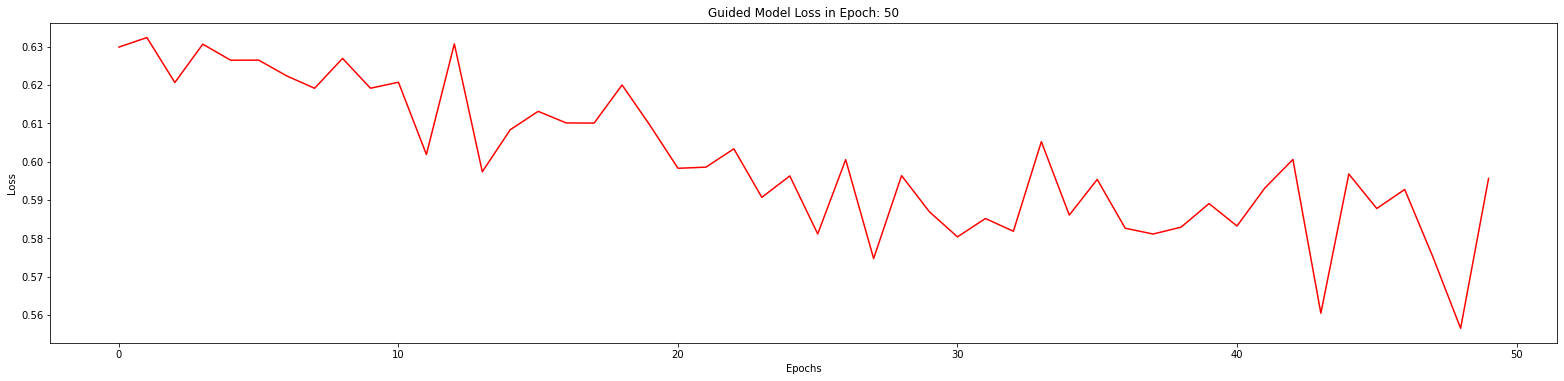

Epoch: 051, GuidedBP Model Loss: 0.5550
Epoch: 052, GuidedBP Model Loss: 0.5431
Epoch: 053, GuidedBP Model Loss: 0.5483
Epoch: 054, GuidedBP Model Loss: 0.5706
Epoch: 055, GuidedBP Model Loss: 0.5652
Epoch: 056, GuidedBP Model Loss: 0.5832
Epoch: 057, GuidedBP Model Loss: 0.5866
Epoch: 058, GuidedBP Model Loss: 0.5700
Epoch: 059, GuidedBP Model Loss: 0.5583
Epoch: 060, GuidedBP Model Loss: 0.5396
Epoch: 061, GuidedBP Model Loss: 0.5578
Epoch: 062, GuidedBP Model Loss: 0.5518
Epoch: 063, GuidedBP Model Loss: 0.5473
Epoch: 064, GuidedBP Model Loss: 0.5377
Epoch: 065, GuidedBP Model Loss: 0.5287
Epoch: 066, GuidedBP Model Loss: 0.5488
Epoch: 067, GuidedBP Model Loss: 0.5439
Epoch: 068, GuidedBP Model Loss: 0.5372
Epoch: 069, GuidedBP Model Loss: 0.5470
Epoch: 070, GuidedBP Model Loss: 0.5470
Epoch: 071, GuidedBP Model Loss: 0.5258
Epoch: 072, GuidedBP Model Loss: 0.5413
Epoch: 073, GuidedBP Model Loss: 0.5316
Epoch: 074, GuidedBP Model Loss: 0.5257
Epoch: 075, GuidedBP Model Loss: 0.5331


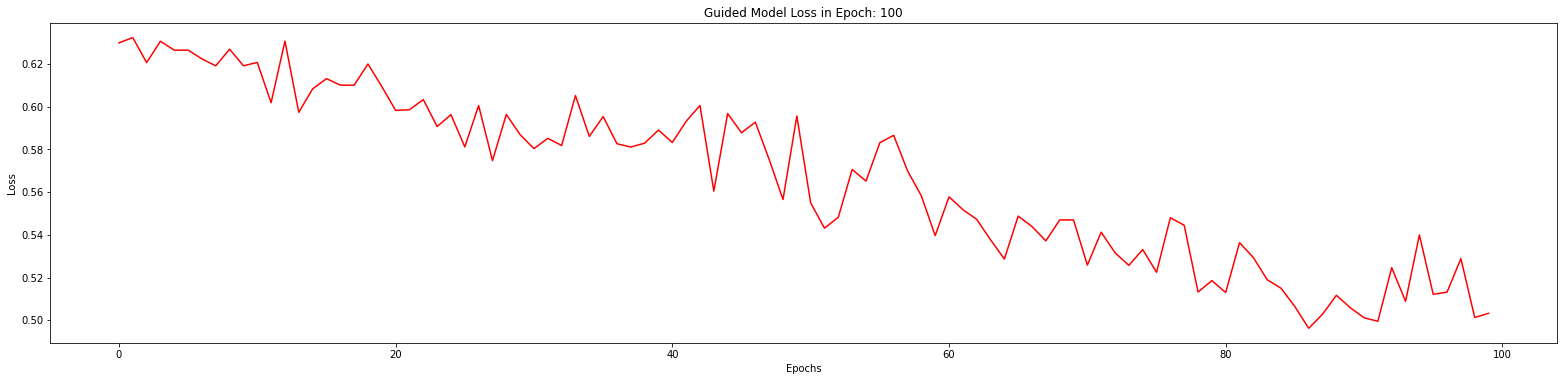

Epoch: 101, GuidedBP Model Loss: 0.5426
Epoch: 102, GuidedBP Model Loss: 0.5232
Epoch: 103, GuidedBP Model Loss: 0.5051
Epoch: 104, GuidedBP Model Loss: 0.4808
Epoch: 105, GuidedBP Model Loss: 0.5046
Epoch: 106, GuidedBP Model Loss: 0.5123
Epoch: 107, GuidedBP Model Loss: 0.5121
Epoch: 108, GuidedBP Model Loss: 0.5224
Epoch: 109, GuidedBP Model Loss: 0.4991
Epoch: 110, GuidedBP Model Loss: 0.5250
Epoch: 111, GuidedBP Model Loss: 0.4819
Epoch: 112, GuidedBP Model Loss: 0.4929
Epoch: 113, GuidedBP Model Loss: 0.4920
Epoch: 114, GuidedBP Model Loss: 0.4951
Epoch: 115, GuidedBP Model Loss: 0.4869
Epoch: 116, GuidedBP Model Loss: 0.5232
Epoch: 117, GuidedBP Model Loss: 0.5003
Epoch: 118, GuidedBP Model Loss: 0.5306
Epoch: 119, GuidedBP Model Loss: 0.4968
Epoch: 120, GuidedBP Model Loss: 0.5220
Epoch: 121, GuidedBP Model Loss: 0.4868
Epoch: 122, GuidedBP Model Loss: 0.5526
Epoch: 123, GuidedBP Model Loss: 0.4816
Epoch: 124, GuidedBP Model Loss: 0.5072
Epoch: 125, GuidedBP Model Loss: 0.5103


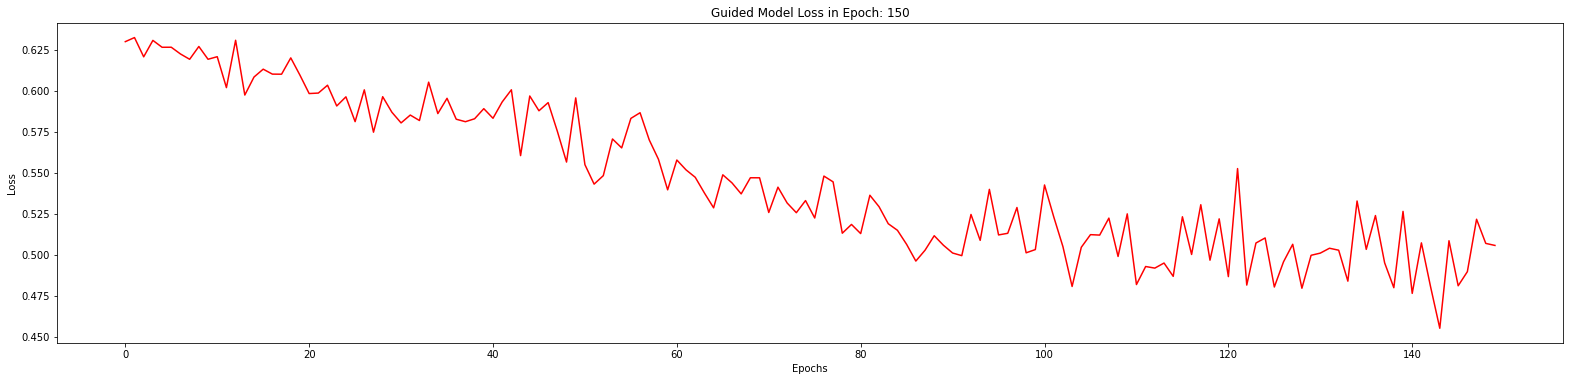

Epoch: 151, GuidedBP Model Loss: 0.4964
Epoch: 152, GuidedBP Model Loss: 0.4821
Epoch: 153, GuidedBP Model Loss: 0.4849
Epoch: 154, GuidedBP Model Loss: 0.4845
Epoch: 155, GuidedBP Model Loss: 0.5021
Epoch: 156, GuidedBP Model Loss: 0.4503
Epoch: 157, GuidedBP Model Loss: 0.5071
Epoch: 158, GuidedBP Model Loss: 0.4751
Epoch: 159, GuidedBP Model Loss: 0.4913
Epoch: 160, GuidedBP Model Loss: 0.4849
Epoch: 161, GuidedBP Model Loss: 0.4813
Epoch: 162, GuidedBP Model Loss: 0.5341
Epoch: 163, GuidedBP Model Loss: 0.5024
Epoch: 164, GuidedBP Model Loss: 0.5163
Epoch: 165, GuidedBP Model Loss: 0.4758
Epoch: 166, GuidedBP Model Loss: 0.5032
Epoch: 167, GuidedBP Model Loss: 0.4728
Epoch: 168, GuidedBP Model Loss: 0.4537
Epoch: 169, GuidedBP Model Loss: 0.5186
Epoch: 170, GuidedBP Model Loss: 0.4915
Epoch: 171, GuidedBP Model Loss: 0.4904
Epoch: 172, GuidedBP Model Loss: 0.4825
Epoch: 173, GuidedBP Model Loss: 0.4940
Epoch: 174, GuidedBP Model Loss: 0.5240
Epoch: 175, GuidedBP Model Loss: 0.4704


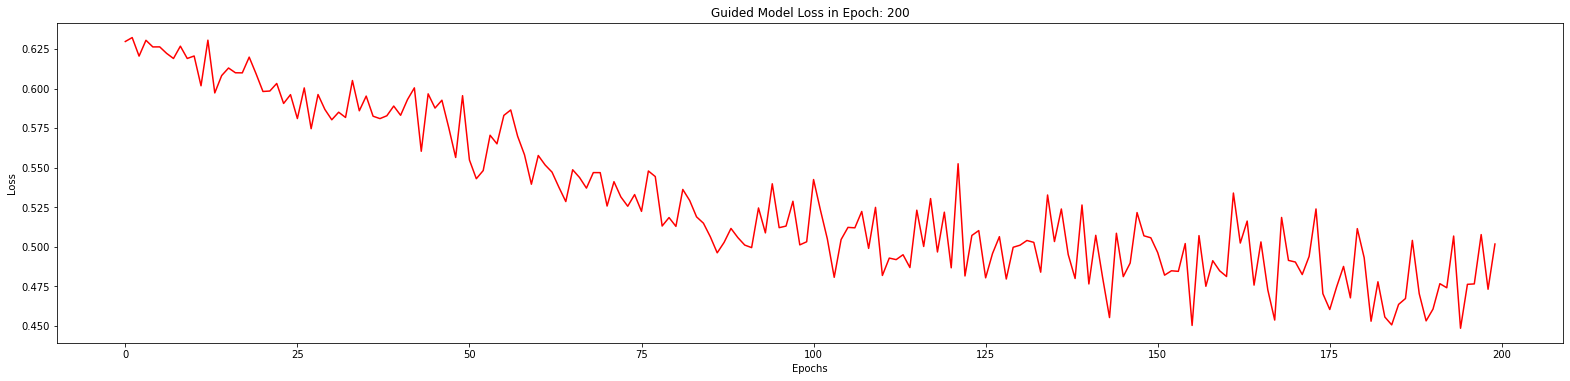

In [23]:
EPOCHS = 200
load_index = 0
if load_index != 0:
  model_GCN, optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [24]:
def GuidedBP_test(test_loader):
  predictions = []
  GuidedBP_model_GCN.eval()
  correct = 0
  for batched_data in test_loader:  
    post_conv1, post_conv2, out_readout, GuidedBP_test_out = GuidedBP_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)  
    GuidedBP_test_pred = GuidedBP_test_out.argmax(dim=1)
    predictions.append(GuidedBP_test_pred)  
    correct += int((GuidedBP_test_pred == batched_data.y).sum())  
  return correct / len(test_loader.dataset), predictions[0].detach().tolist()

In [25]:
GuidedBP_test_acc, predictions = GuidedBP_test(test_loader)
print(f'Test Accuracy: {GuidedBP_test_acc:.4f}')

Test Accuracy: 0.5789


In [26]:
print(predictions)
real_labels = []
for graph in test_dataset:
  real_labels.append(graph.y.detach().tolist()[0])
print(real_labels)

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1]
[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]


In [27]:
Auc_Roc = metrics.roc_auc_score(real_labels, predictions)
precision, recall, thresholds = metrics.precision_recall_curve(real_labels, predictions)
Auc_Prc = metrics.auc(y=precision, x=recall)
Acc = metrics.accuracy_score(real_labels, predictions, normalize=True)
Acc2 = metrics.accuracy_score(real_labels, predictions, normalize=False)
print(Auc_Roc, Auc_Prc, Acc, Acc2)

0.5327380952380952 0.7731950067476383 0.5789473684210527 22


## **Instance Specific Time**

In [28]:
def instance_time(test_dataset):
  instance_based_time = []
  GuidedBP_model_GCN.eval()
  correct = 0
  for batched_data in test_dataset:
    start_generation = perf_counter()
    post_conv1, post_conv2, out_readout, GuidedBP_test_out = GuidedBP_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)  
    Guided_test_pred = GuidedBP_test_out.argmax(dim=1)
    consumed_time = perf_counter() - start_generation
    instance_based_time.append(consumed_time)    
  return instance_based_time

In [29]:
times = instance_time(test_dataset)
print(f'Test Instance based Time: {times}')

Test Instance based Time: [0.007191912999985561, 0.001616720000015448, 0.0011335500000200227, 0.00107126599999674, 0.0010396979999995892, 0.0009821979999742325, 0.0009801520000110031, 0.0009776179999789747, 0.0010018009999726019, 0.0009677030000148079, 0.0009555080000041016, 0.0009696050000229661, 0.0009646679999946173, 0.0009979199999747834, 0.0010124469999936991, 0.001021227999956409, 0.001024815999983275, 0.0009701559999939491, 0.000956627999983084, 0.001264246000005187, 0.0010779820000266227, 0.0011537780000026032, 0.001009817000010571, 0.0010130940000294686, 0.0009819739999556987, 0.0009937130000139405, 0.0010855650000394235, 0.0012225490000332684, 0.0011190179999971406, 0.000985832000026221, 0.0009808529999872917, 0.0009882869999842114, 0.0012495779999994738, 0.0009636479999812764, 0.0009714070000086394, 0.0009642849999522696, 0.000984191999975792, 0.0009945300000140378]


# **Gradients of GuidedBP**


In [30]:
def accumulate_gradients(model_for_you):
  before_guidance = []
  after_guidance = []
  
  for name, param in model_for_you.named_parameters():

    if name == "conv1.bias":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())
    if name == "conv1.lin.weight":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())

    if name == "conv2.bias":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())
    if name == "conv2.lin.weight":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())

    if name == "conv3.bias":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())
    if name == "conv3.lin.weight":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())

    if name == "lin.bias":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())
    if name == "lin.weight":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())
  

  return before_guidance, after_guidance

In [ ]:
holder_of_old_gradients, holder_of_new_gradients = accumulate_gradients(GuidedBP_model_GCN)

# **GuidedBP**
# **Based on the LAST Epoch(and also the last Batch), for each Hidden Node in the Hidden Layers, which Gradient(/dimension) is more important?**

In [ ]:
def guided_model_gradients_of_hidden_nodes(holder_of_new_gradients, holder_of_old_gradients, epoch): 
  layer = 1
  for i in range(len(holder_of_new_gradients[layer])):
    fig1 = plt.figure(figsize=(40,20))

    ax = plt.subplot2grid((3, 2), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Guided Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))
    
    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Normal Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax.plot(holder_of_new_gradients[layer][i], color='r')
    ax2.plot(holder_of_old_gradients[layer][i], color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Gradients_of_Layer " + str(layer) + " Node " + str(i+1) + "_epoch_{:04d}.png".format(epoch))
    plt.show()
  
  layer = 2
  for i in range(len(holder_of_new_gradients[layer+1])):
    fig2 = plt.figure(figsize=(40,20))

    ax = plt.subplot2grid((3, 2), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Guided Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))
    
    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Normal Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax.plot(holder_of_new_gradients[layer+1][i], color='r')
    ax2.plot(holder_of_old_gradients[layer+1][i], color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Gradients_of_Layer " + str(layer) + " Node " + str(i+1) + "_epoch_{:04d}.png".format(epoch))
    plt.show()
  
  layer = 3
  for i in range(len(holder_of_new_gradients[layer+2])):
    fig3 = plt.figure(figsize=(40,20))

    ax = plt.subplot2grid((3, 2), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Guided Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))
    
    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Normal Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax.plot(holder_of_new_gradients[layer+2][i], color='r')
    ax2.plot(holder_of_old_gradients[layer+2][i], color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Gradients_of_Layer " + str(layer) + " Node " + str(i+1) + "_epoch_{:04d}.png".format(epoch))
    plt.show()

  layer = 4
  for i in range(len(holder_of_new_gradients[layer+3])):
    fig4 = plt.figure(figsize=(40,20))

    ax = plt.subplot2grid((3, 2), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Guided Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))
    
    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Normal Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax.plot(holder_of_new_gradients[layer+3][i], color='r')
    ax2.plot(holder_of_old_gradients[layer+3][i], color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Gradients_of_Layer " + str(layer) + " Node " + str(i+1) + "_epoch_{:04d}.png".format(epoch))
    plt.show()

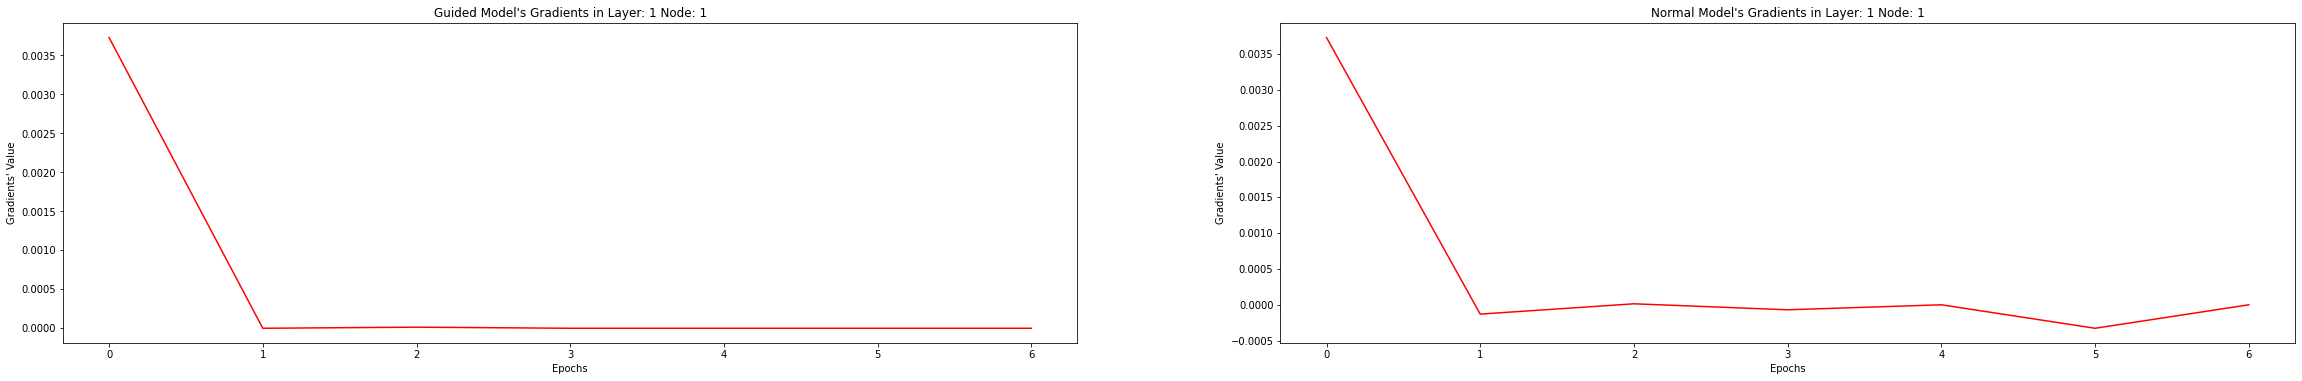

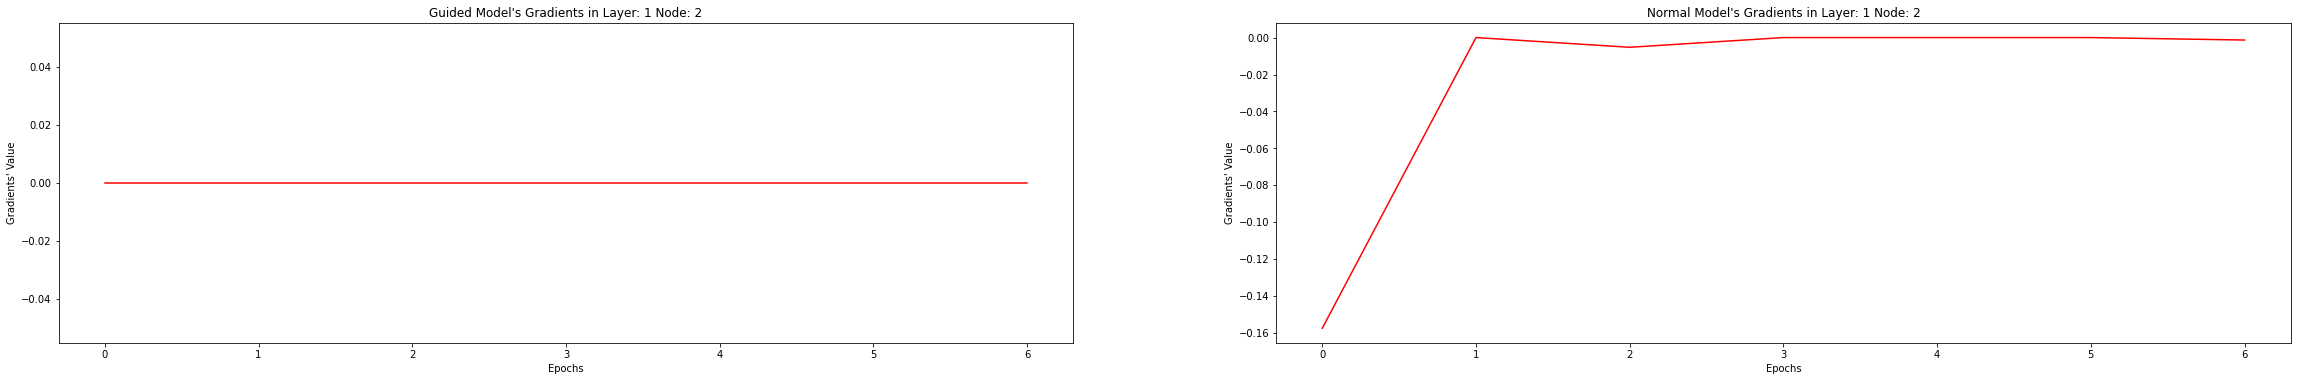

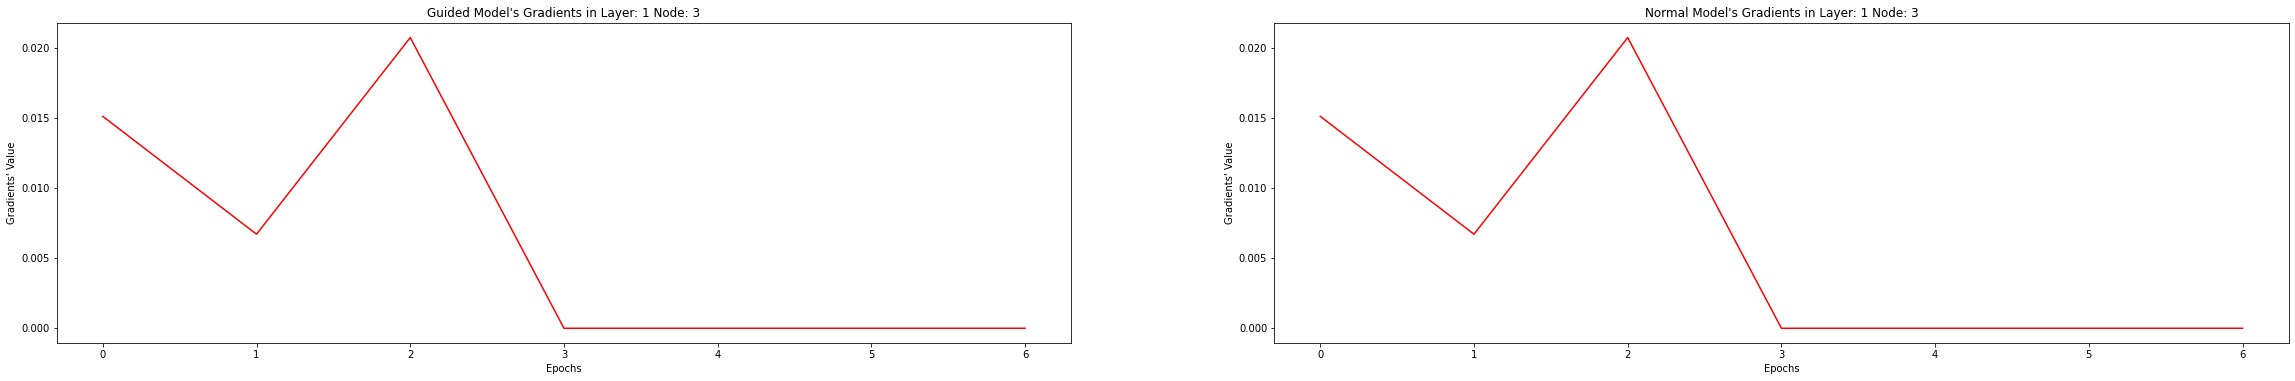

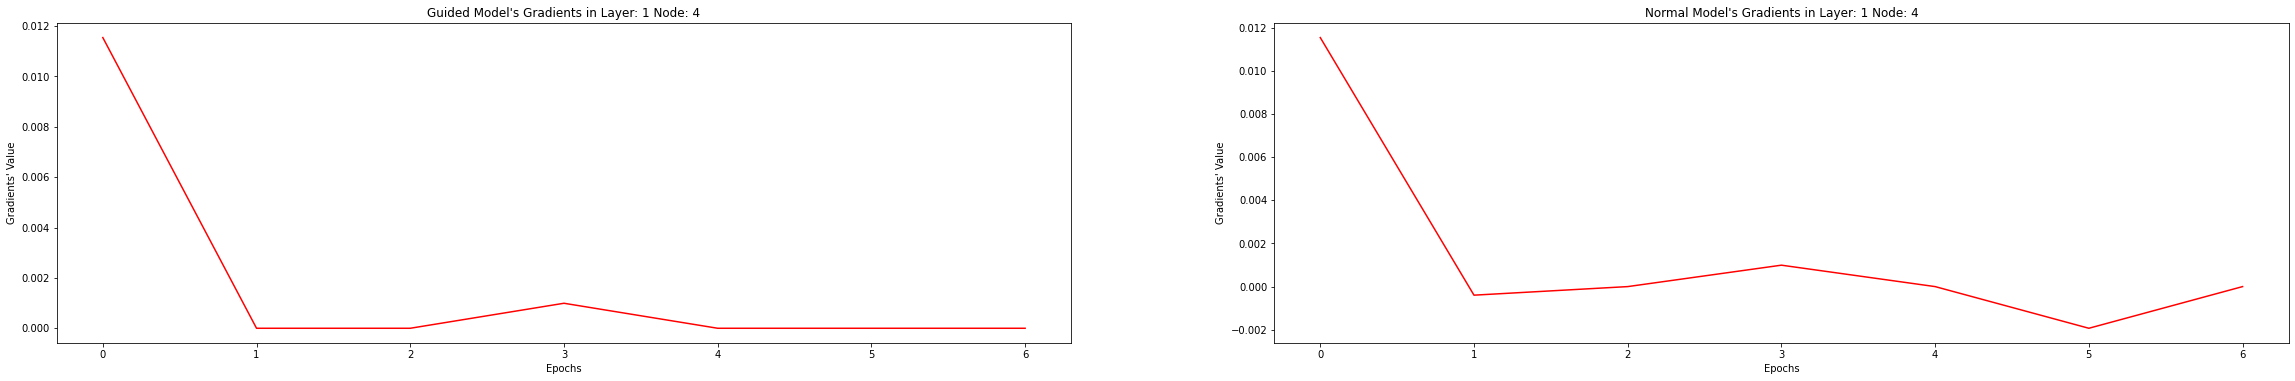

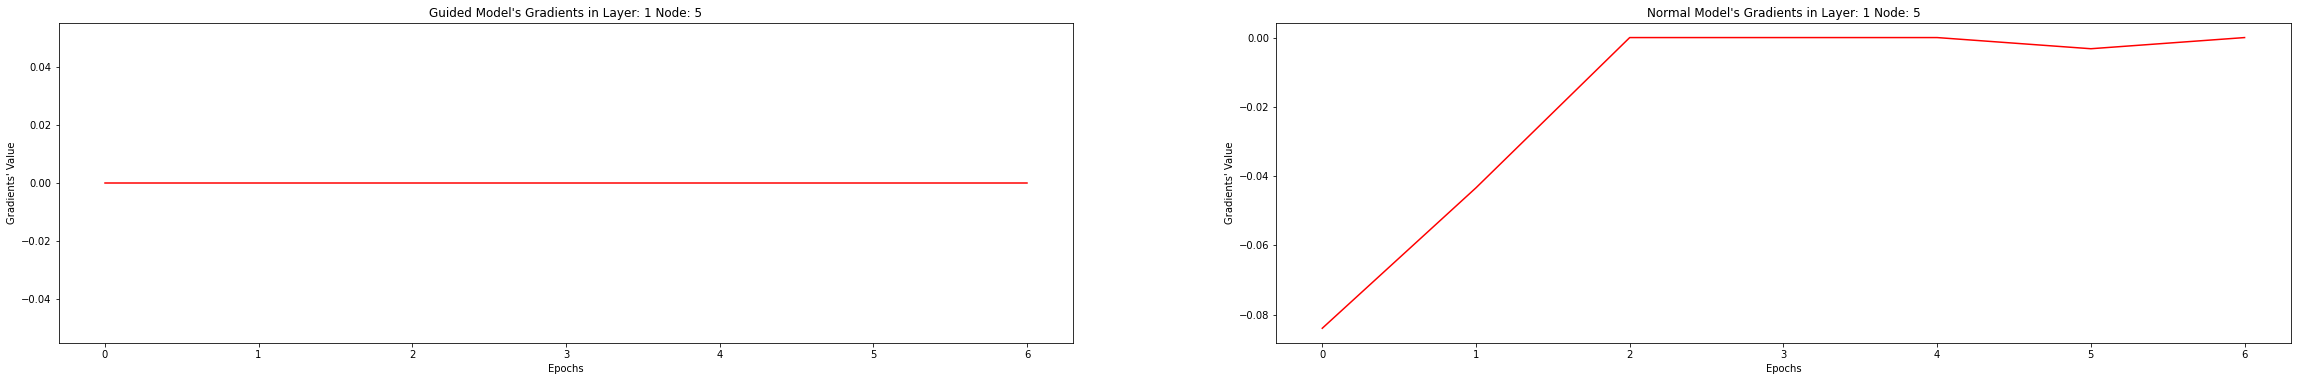

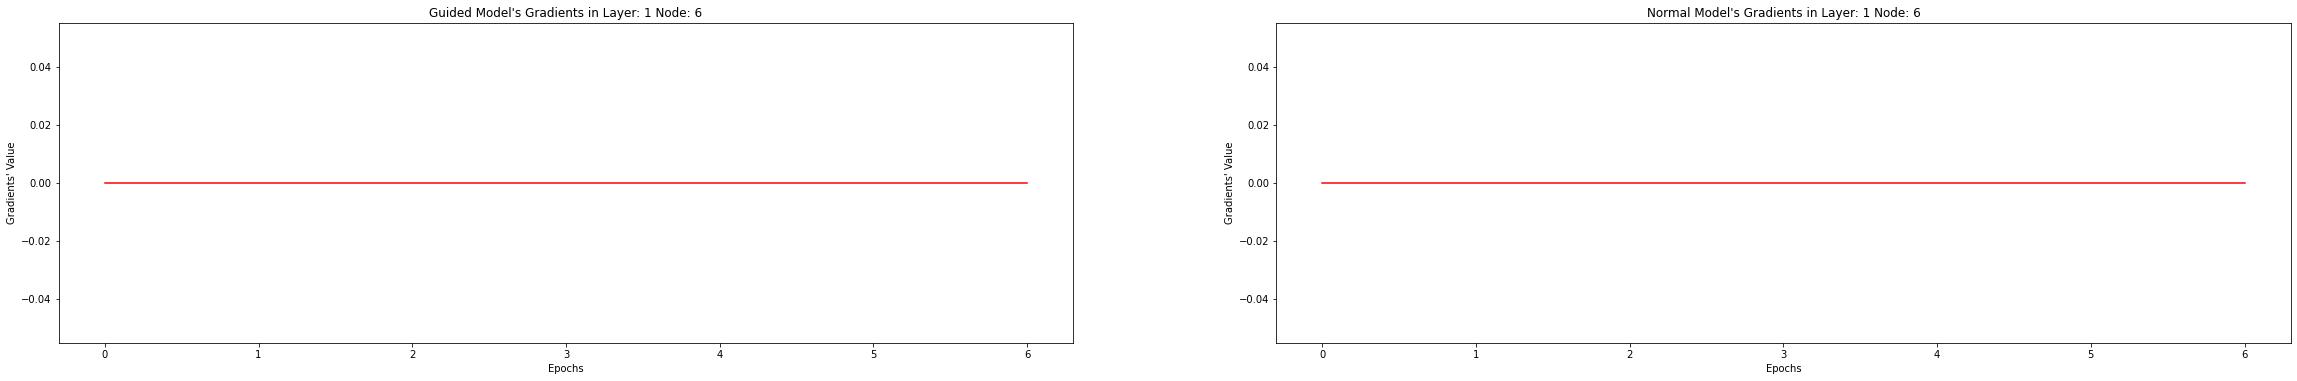

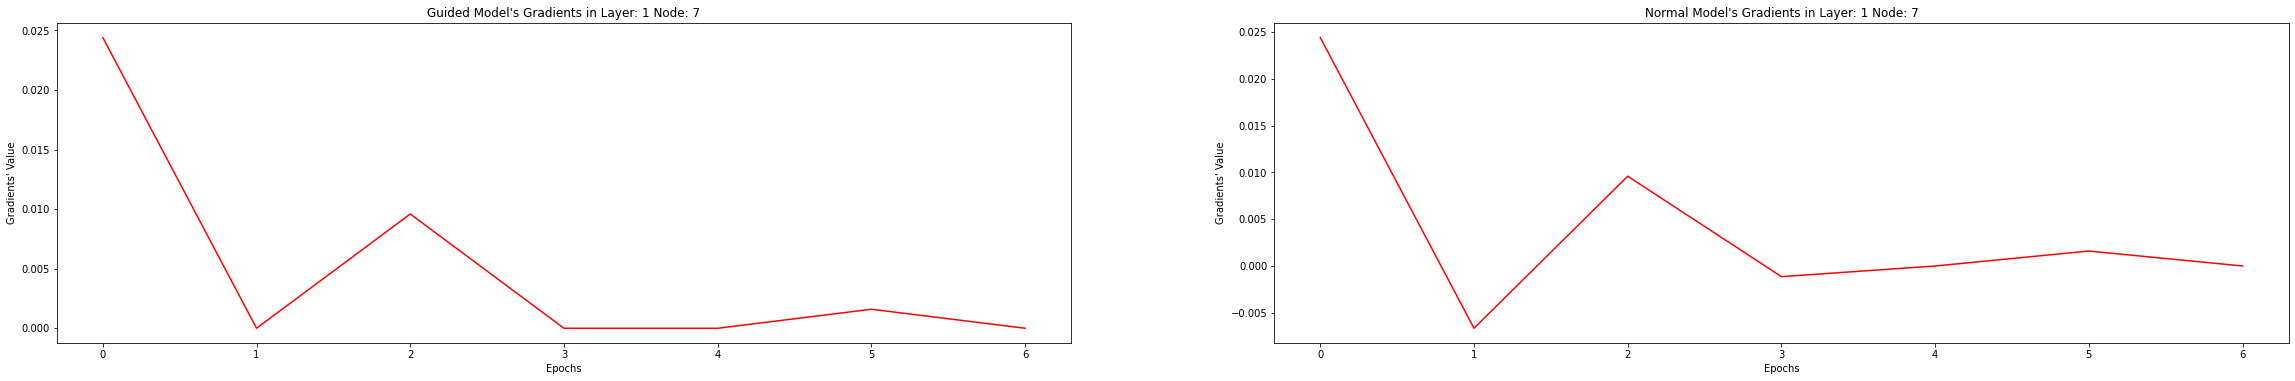

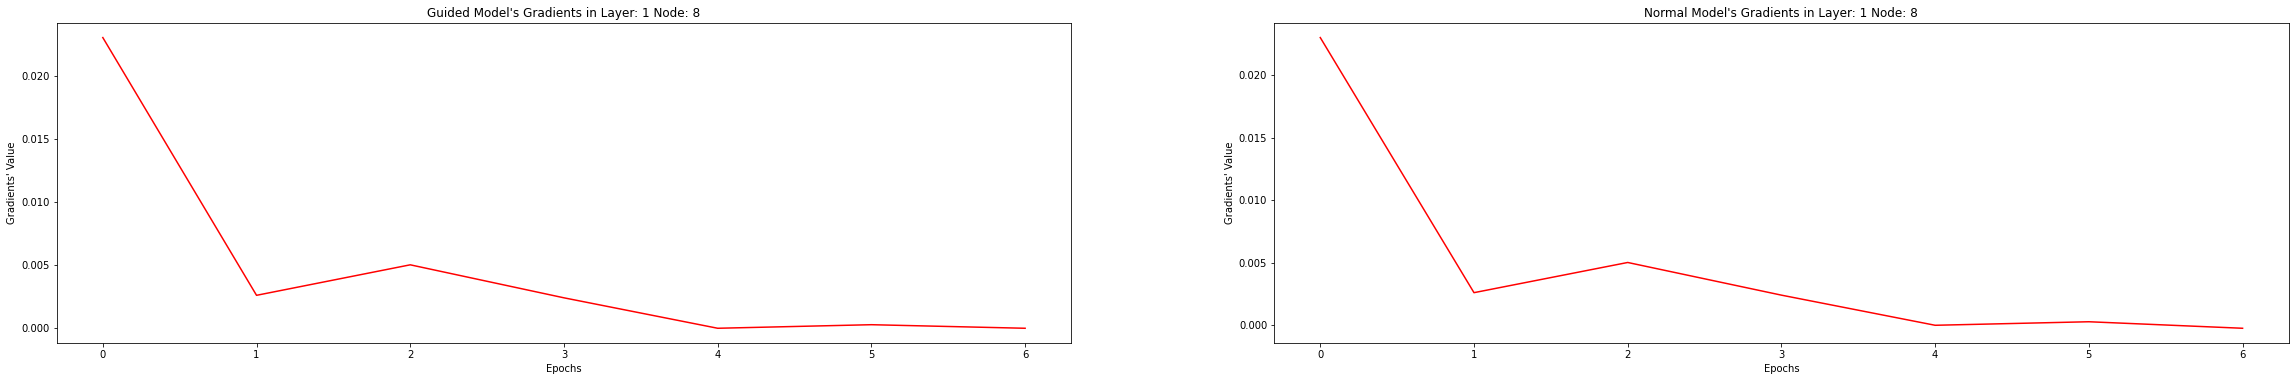

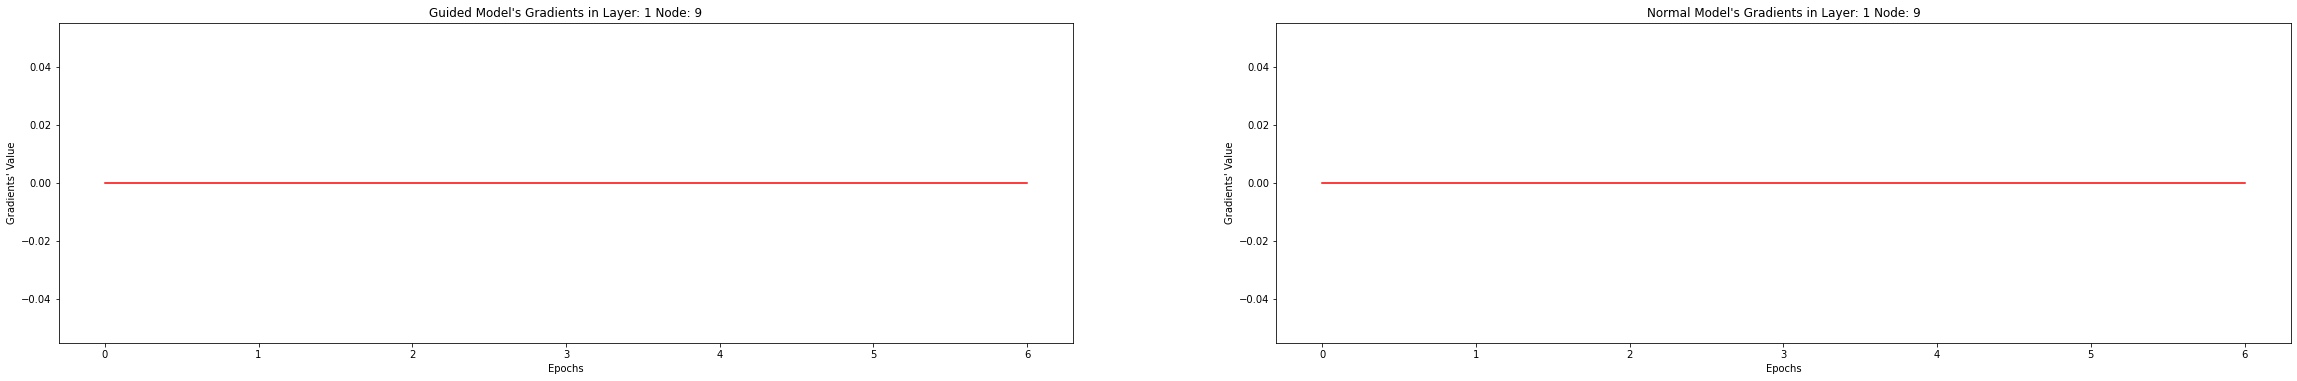

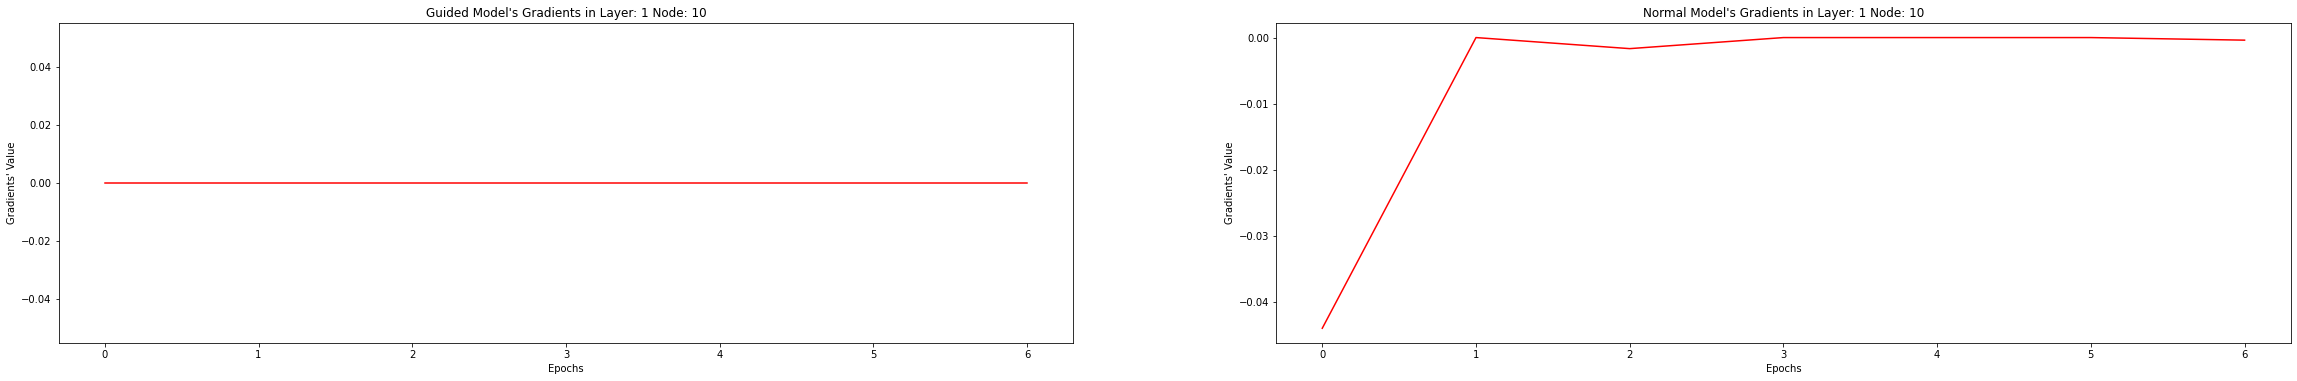

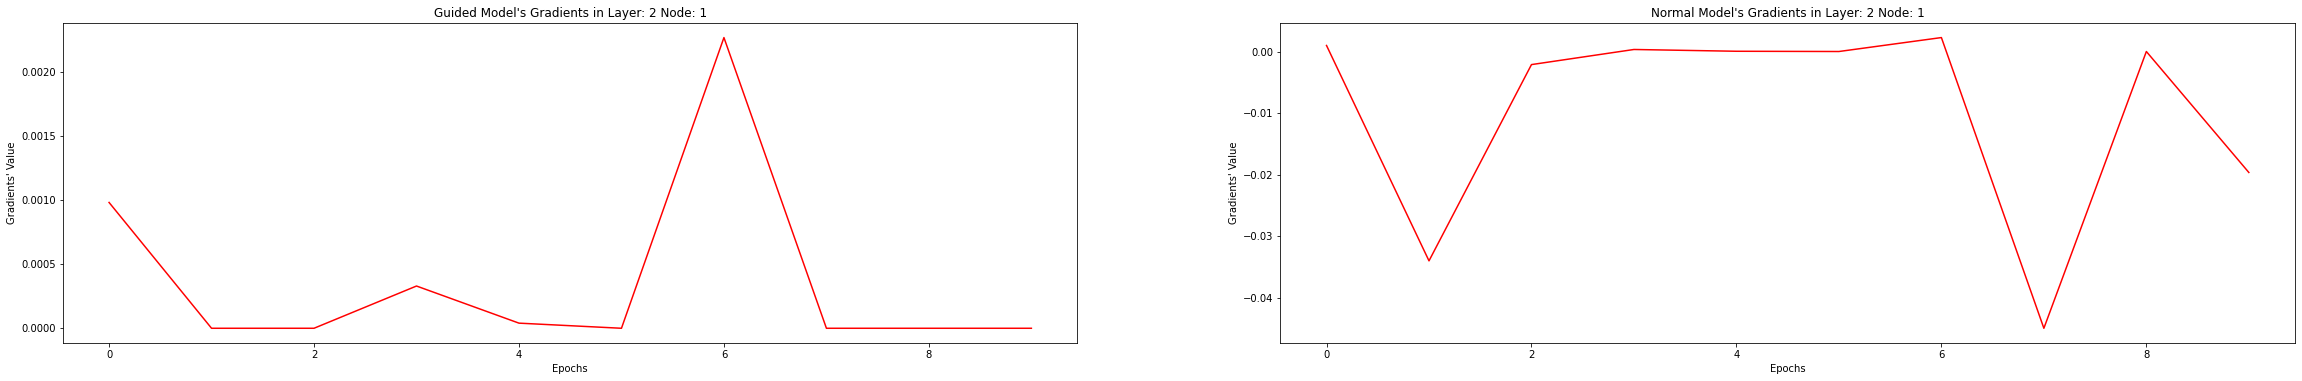

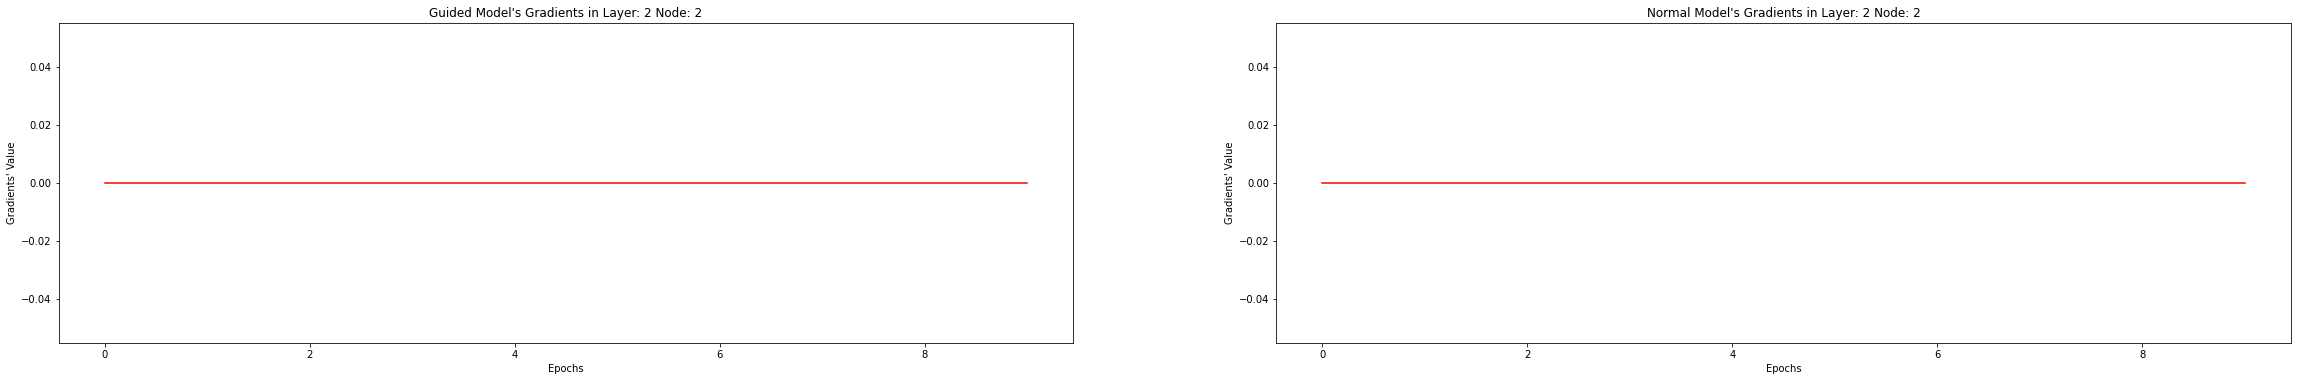

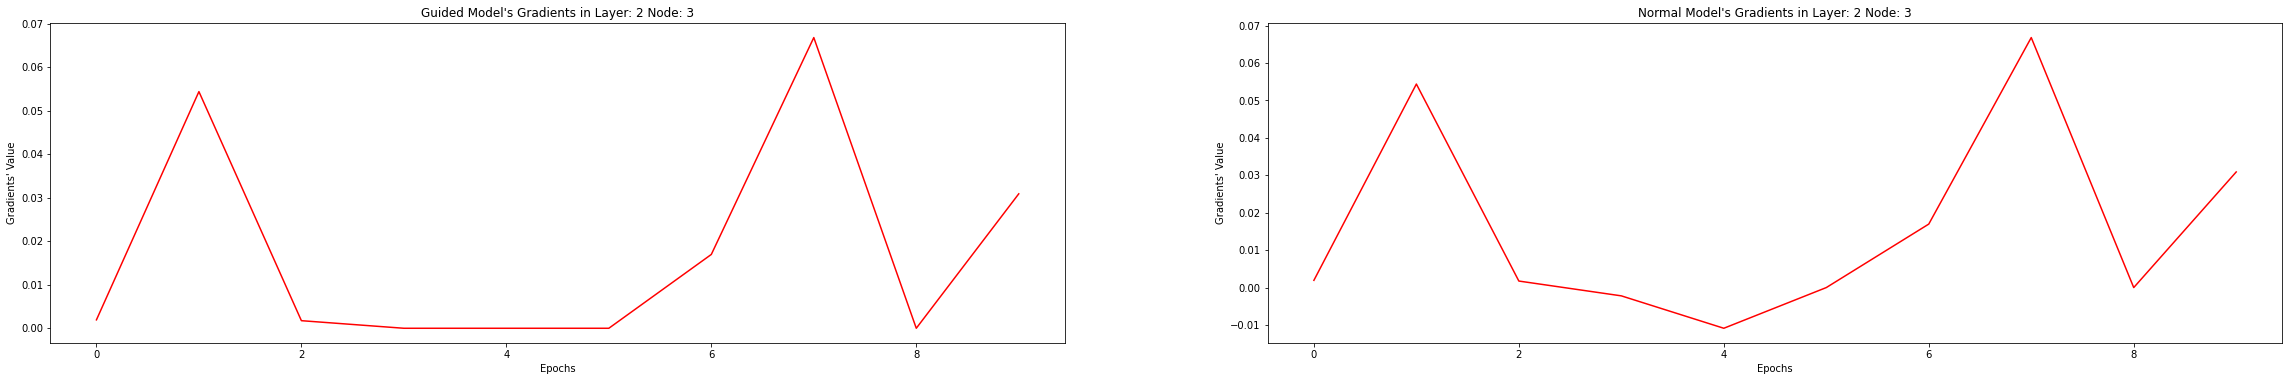

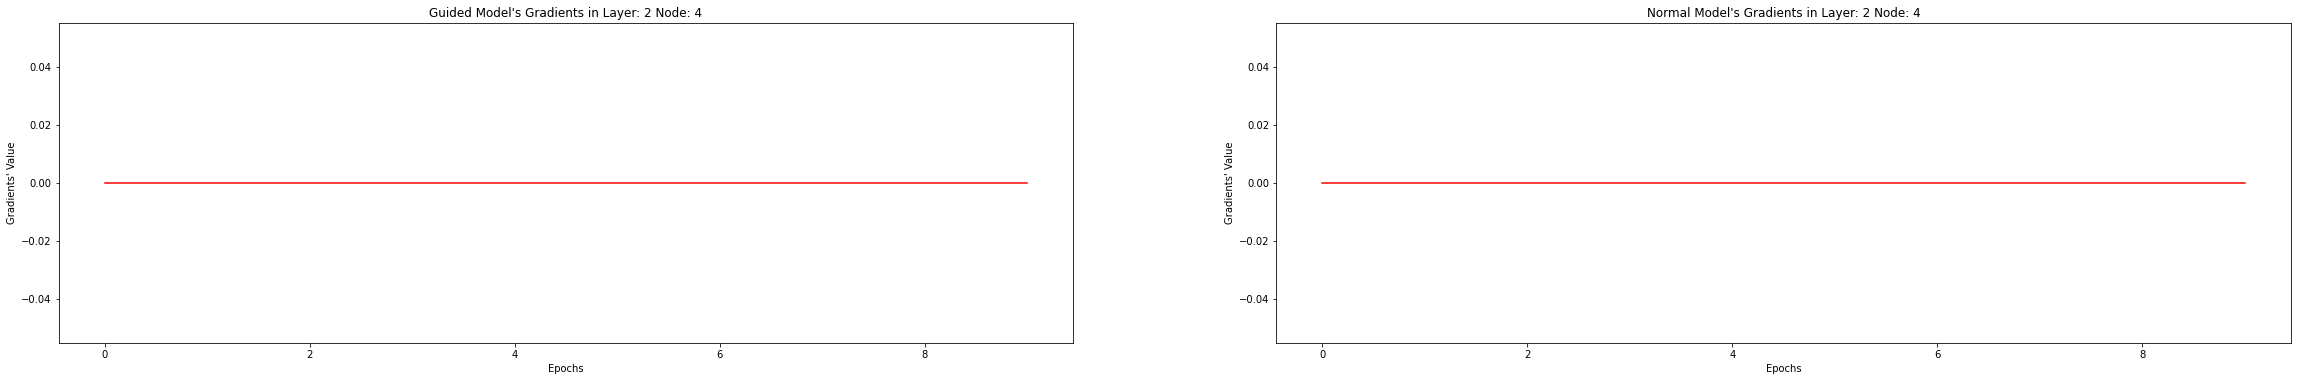

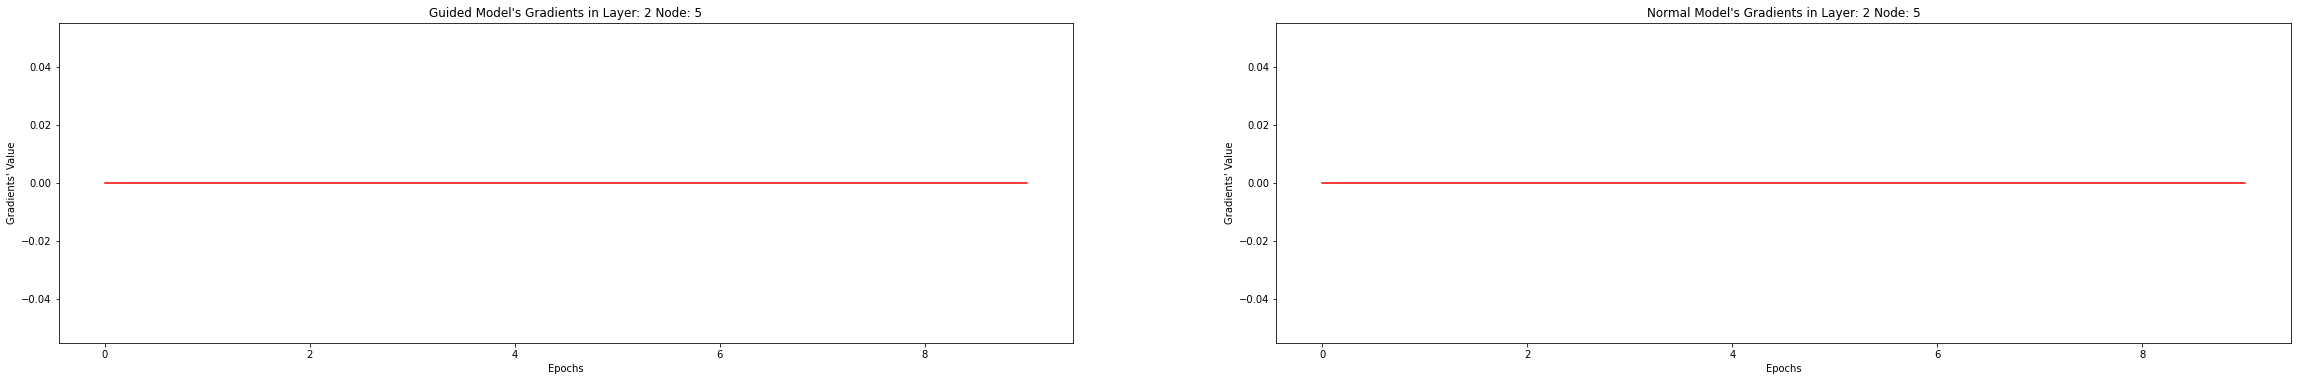

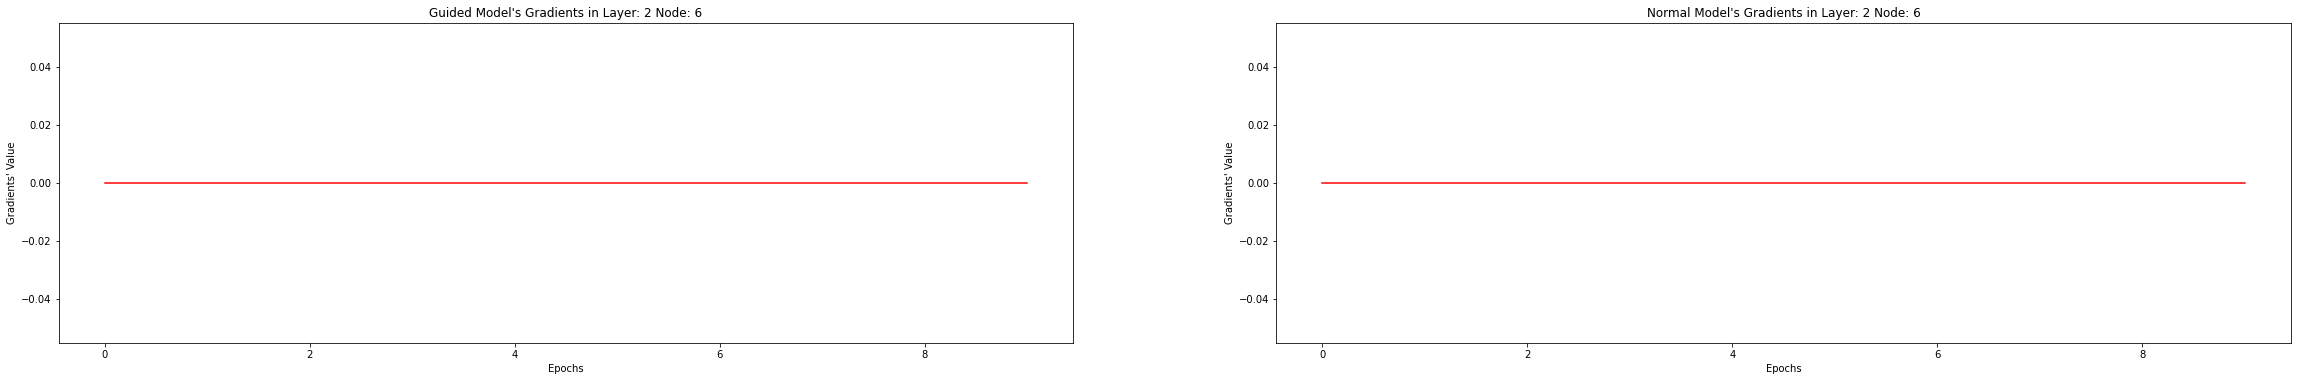

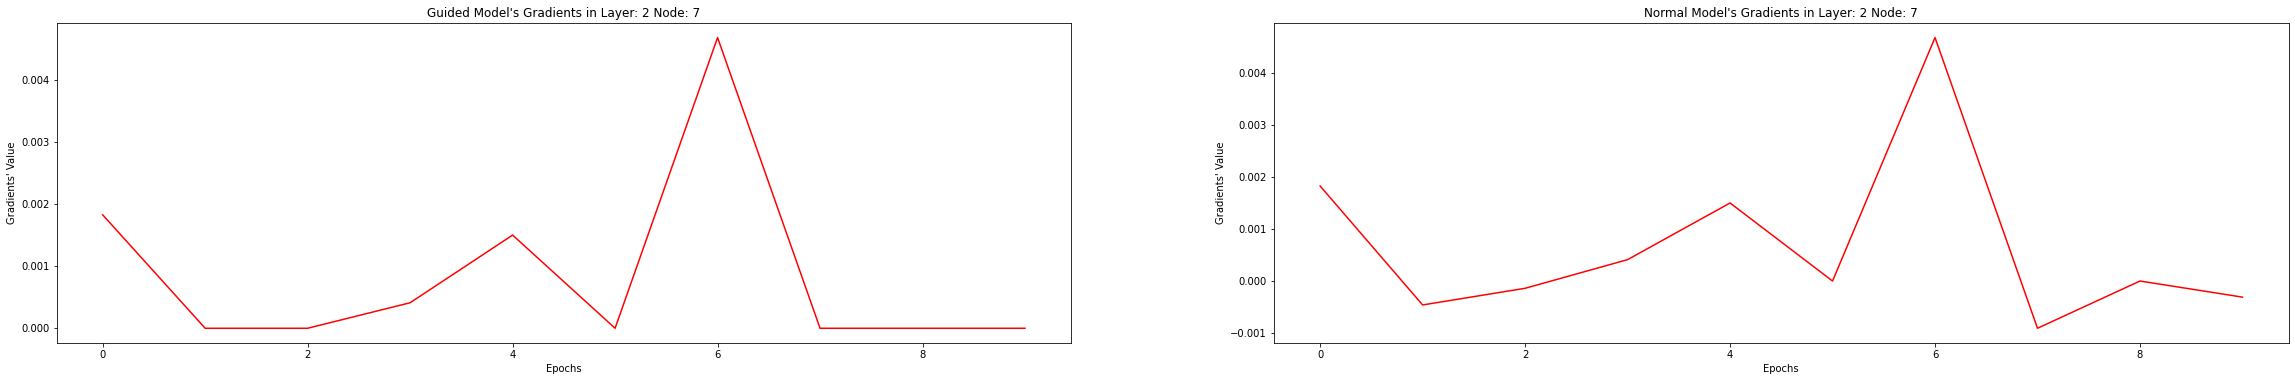

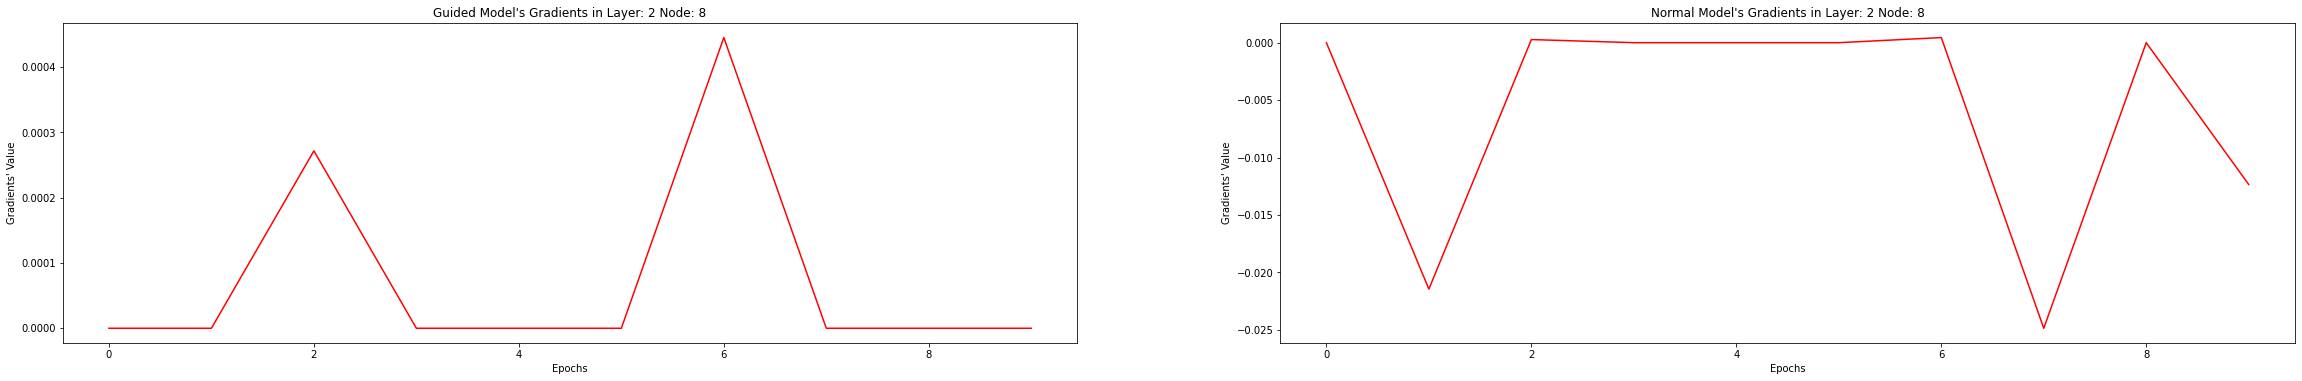

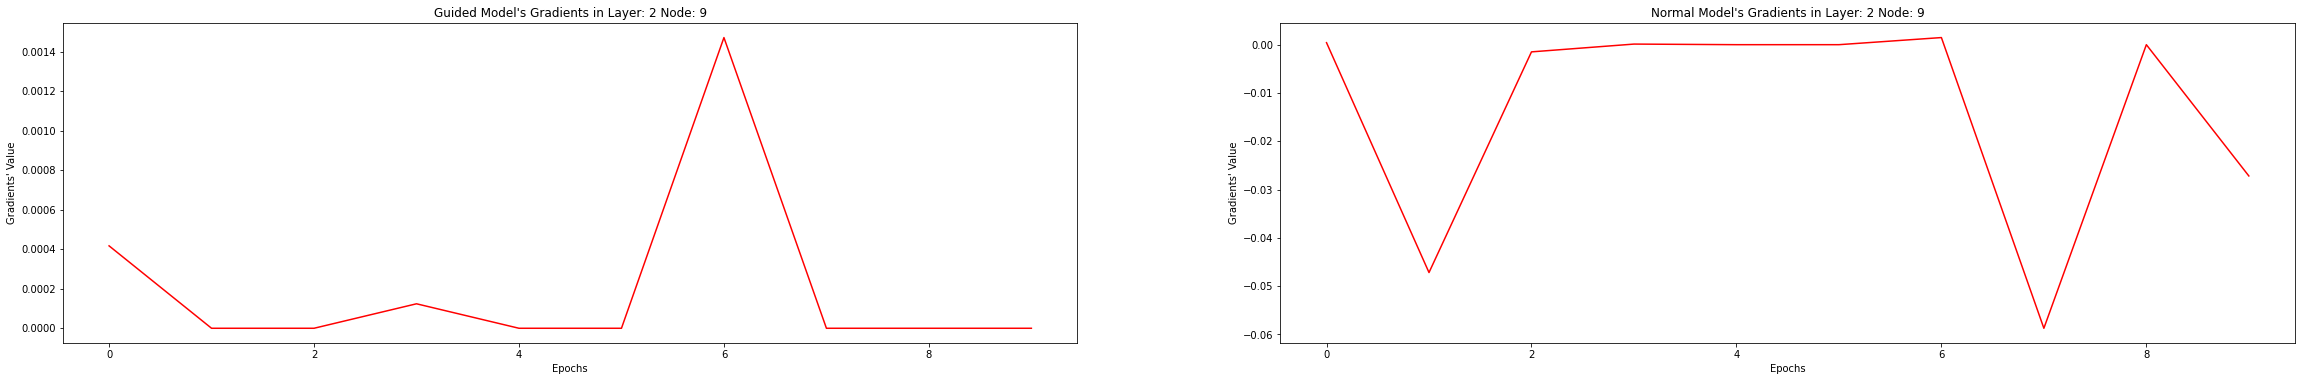

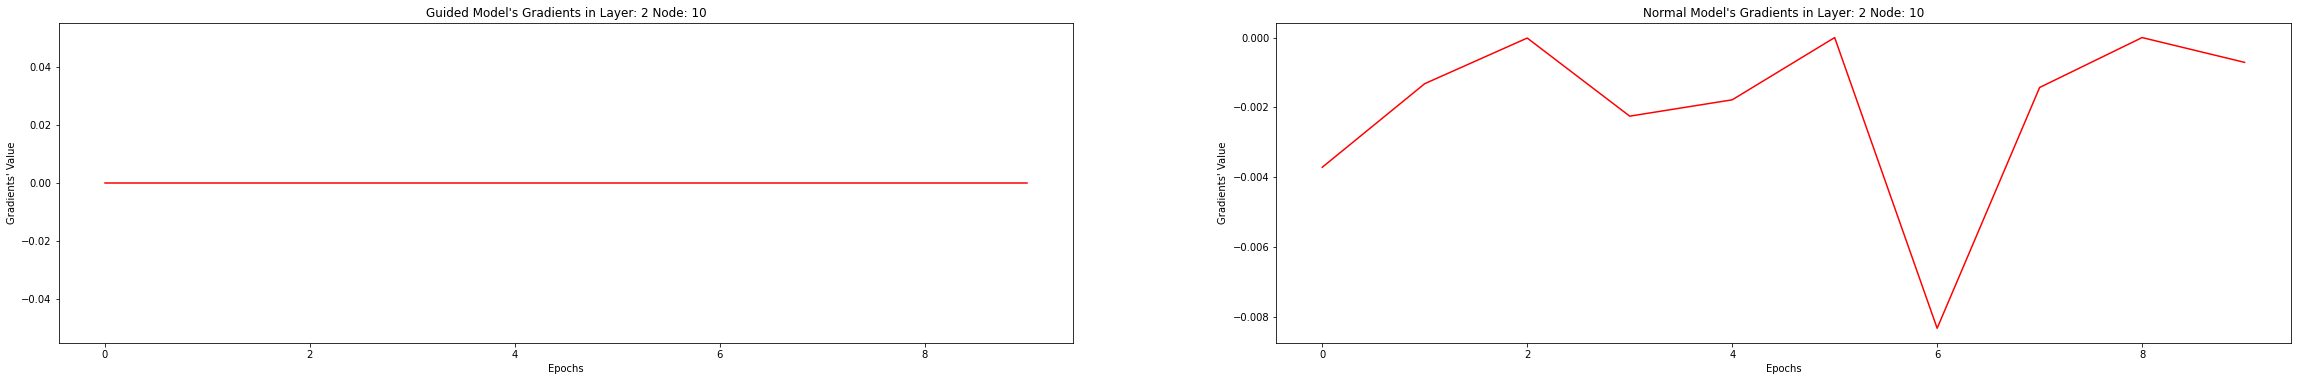

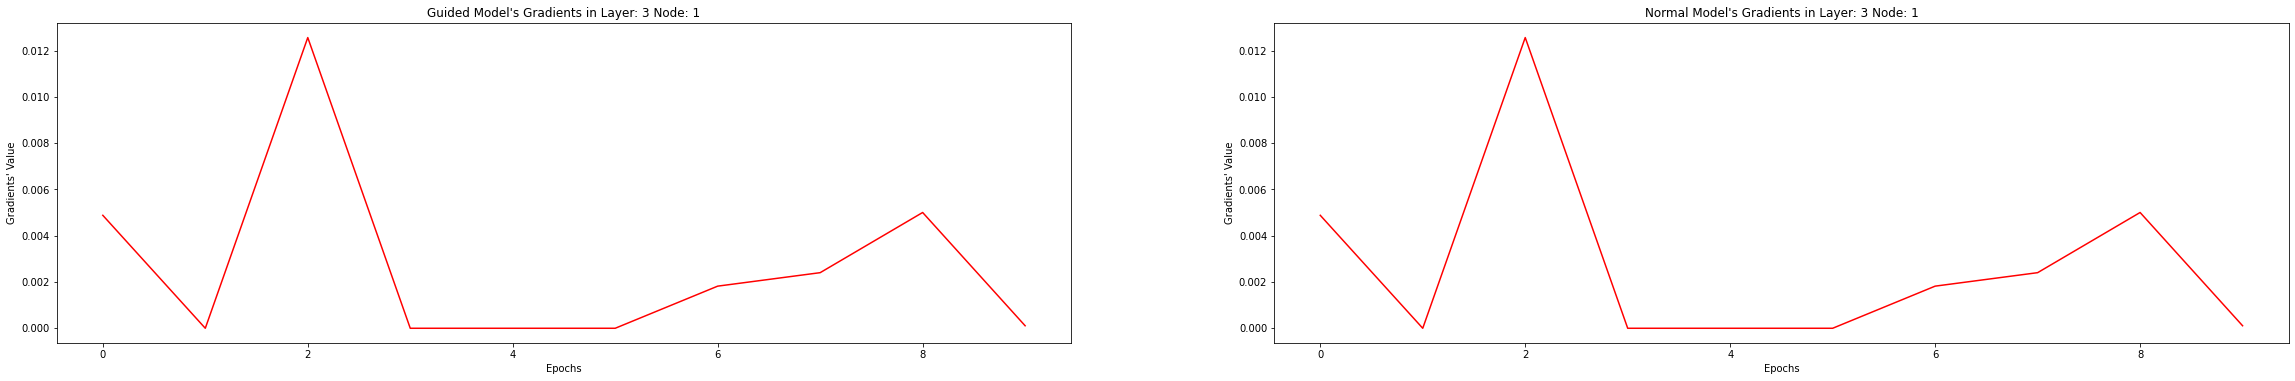

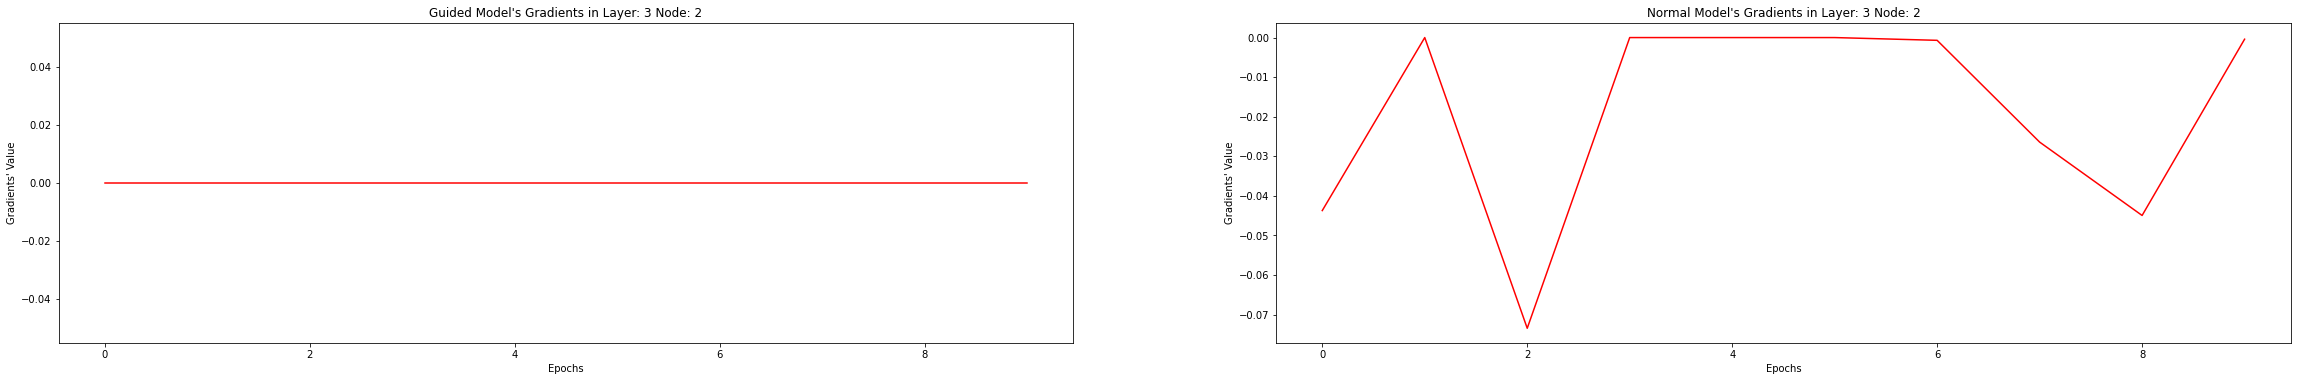

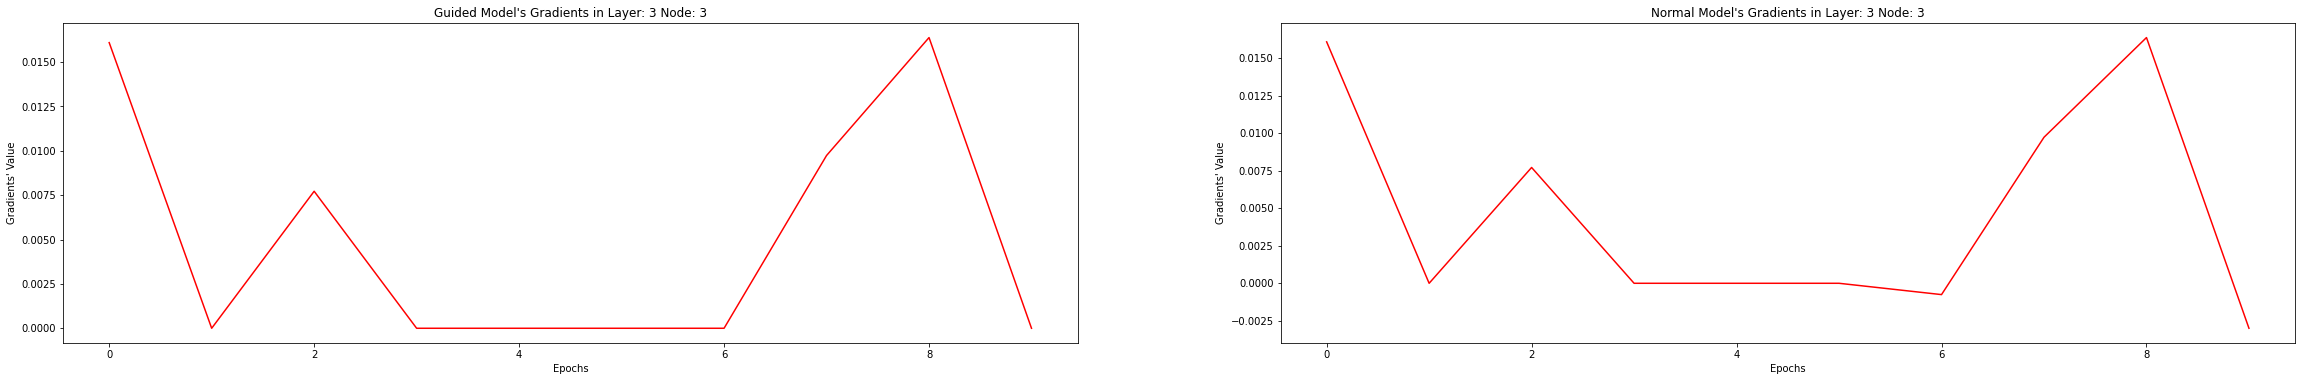

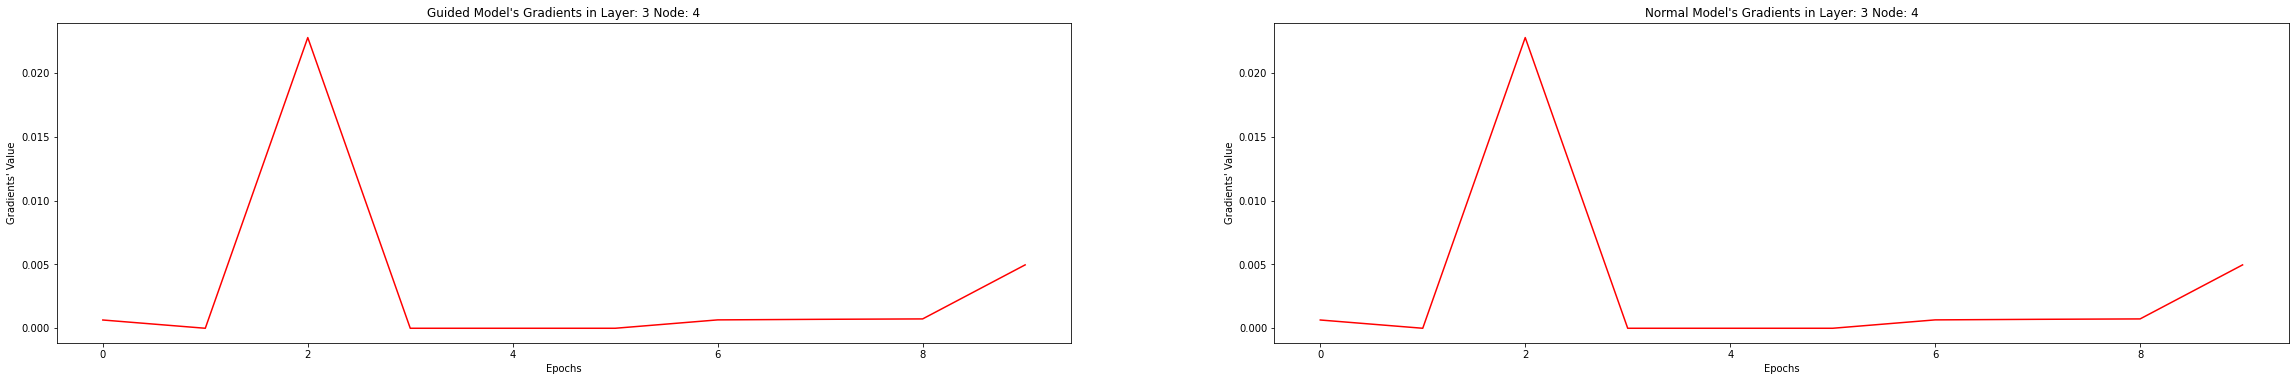

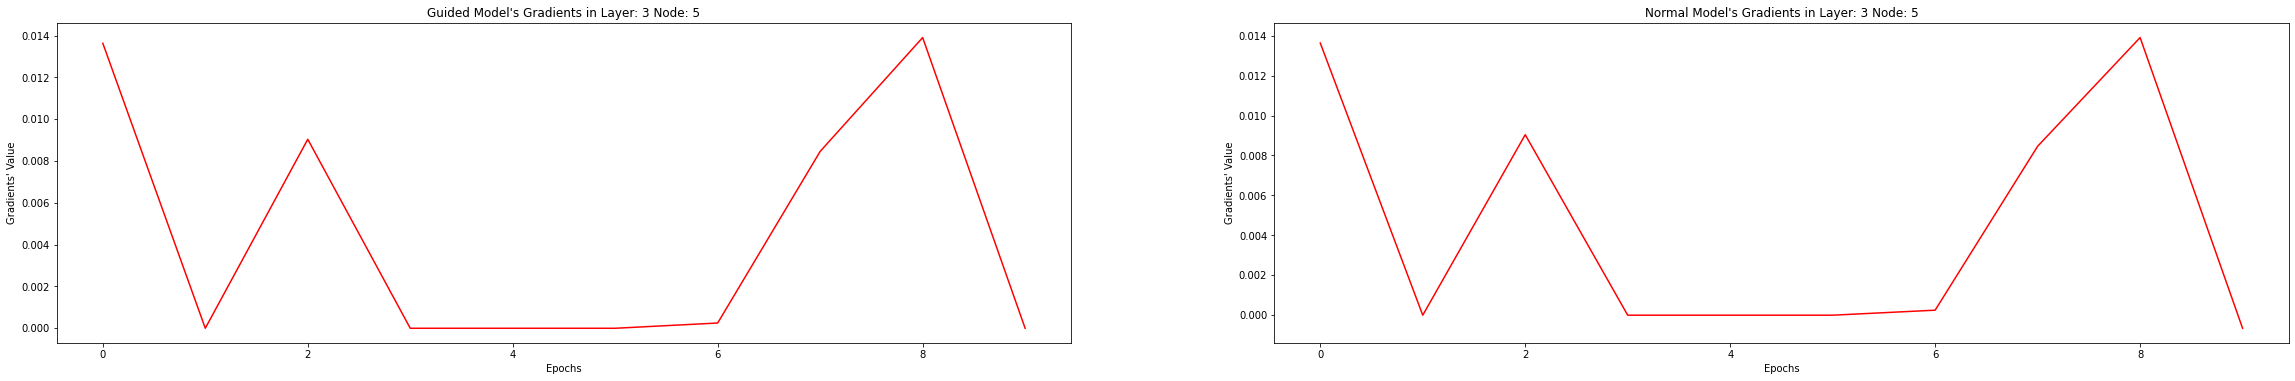

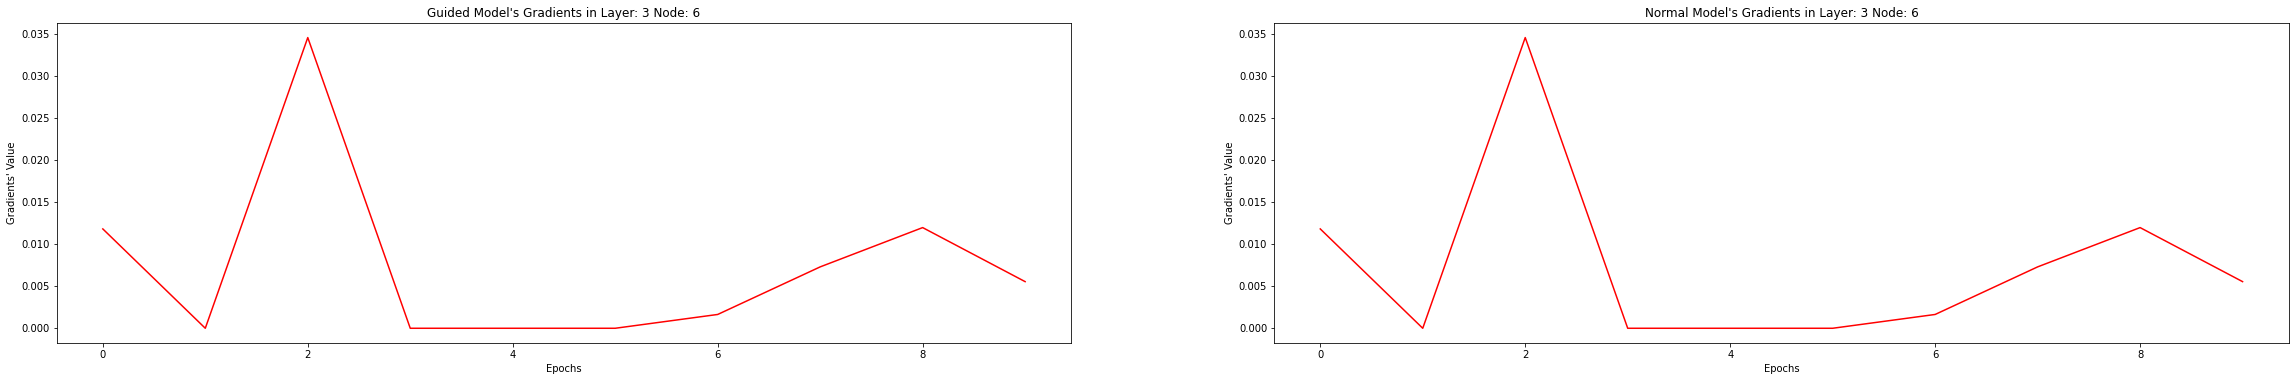

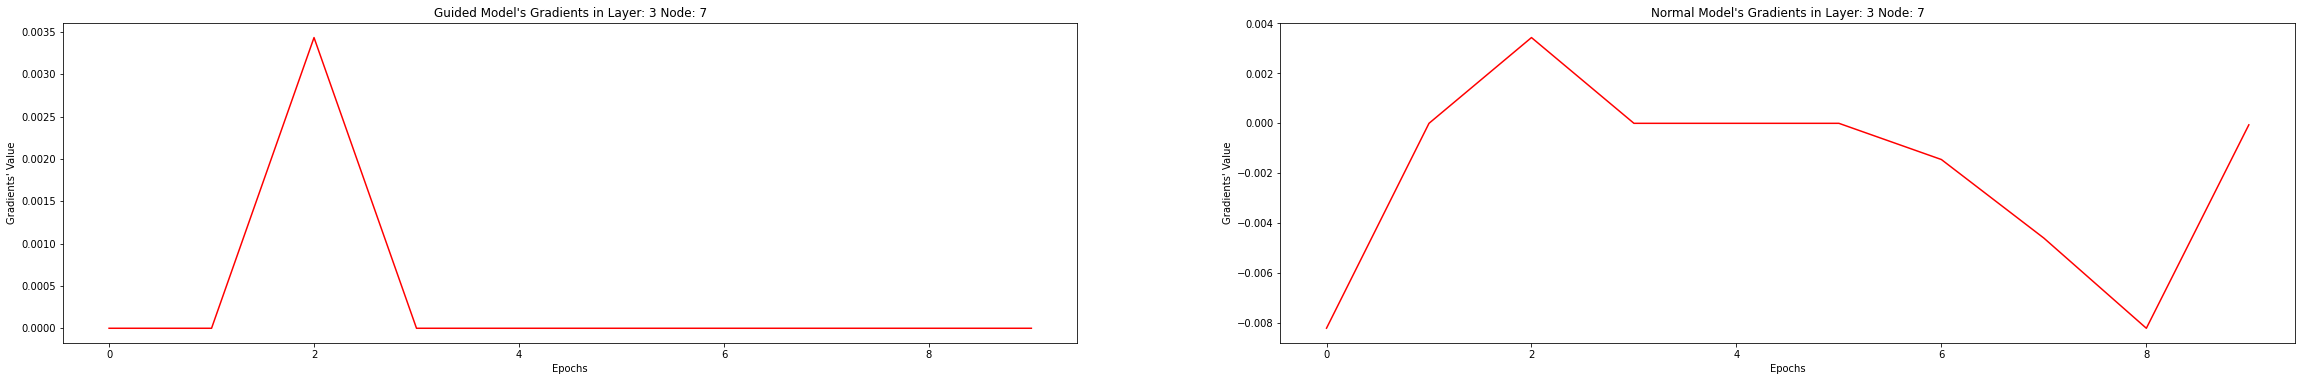

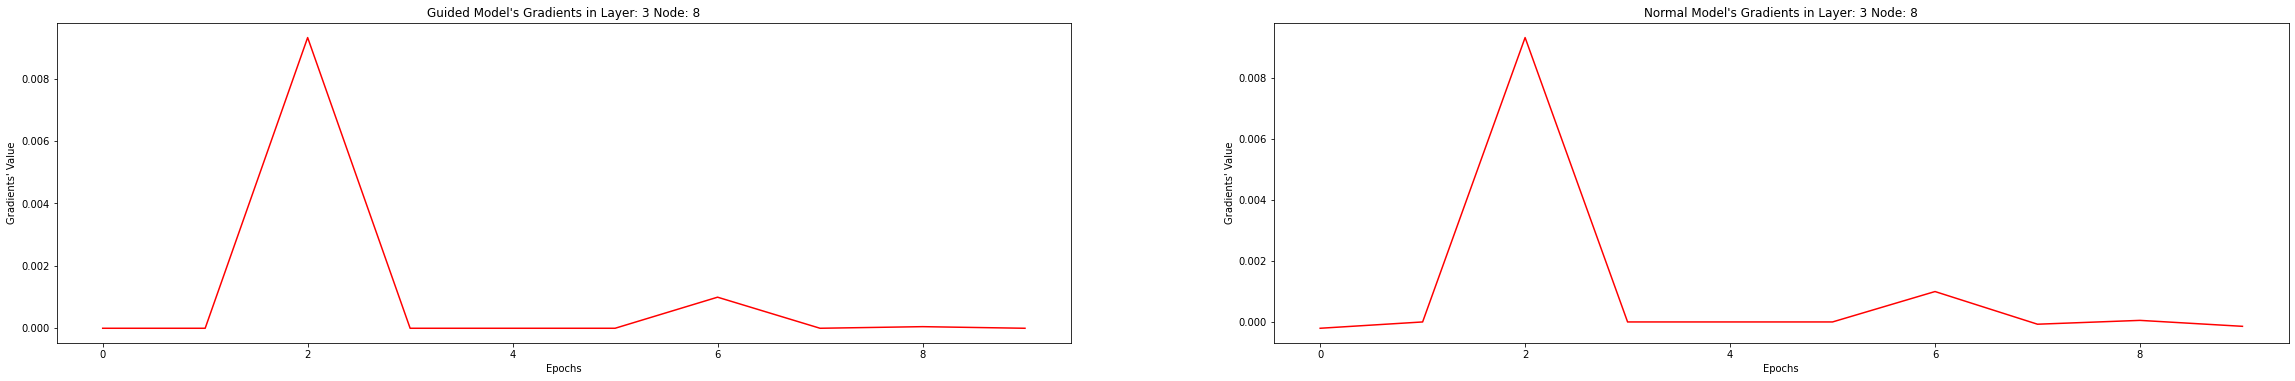

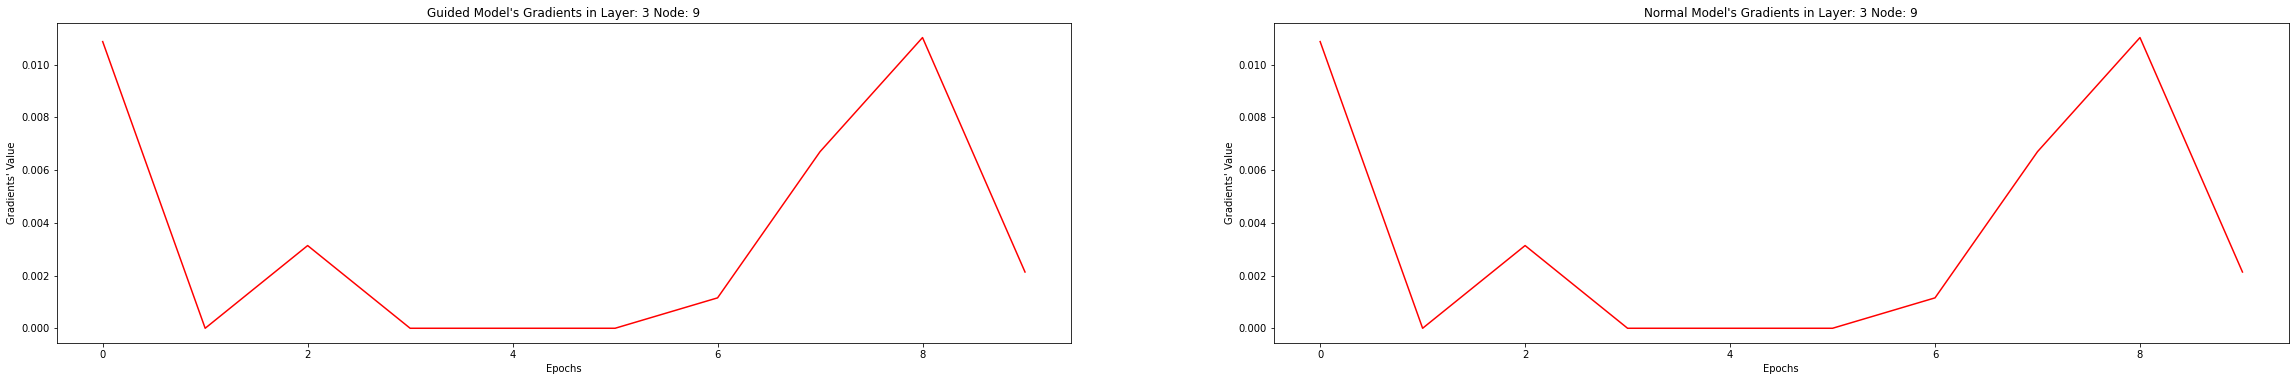

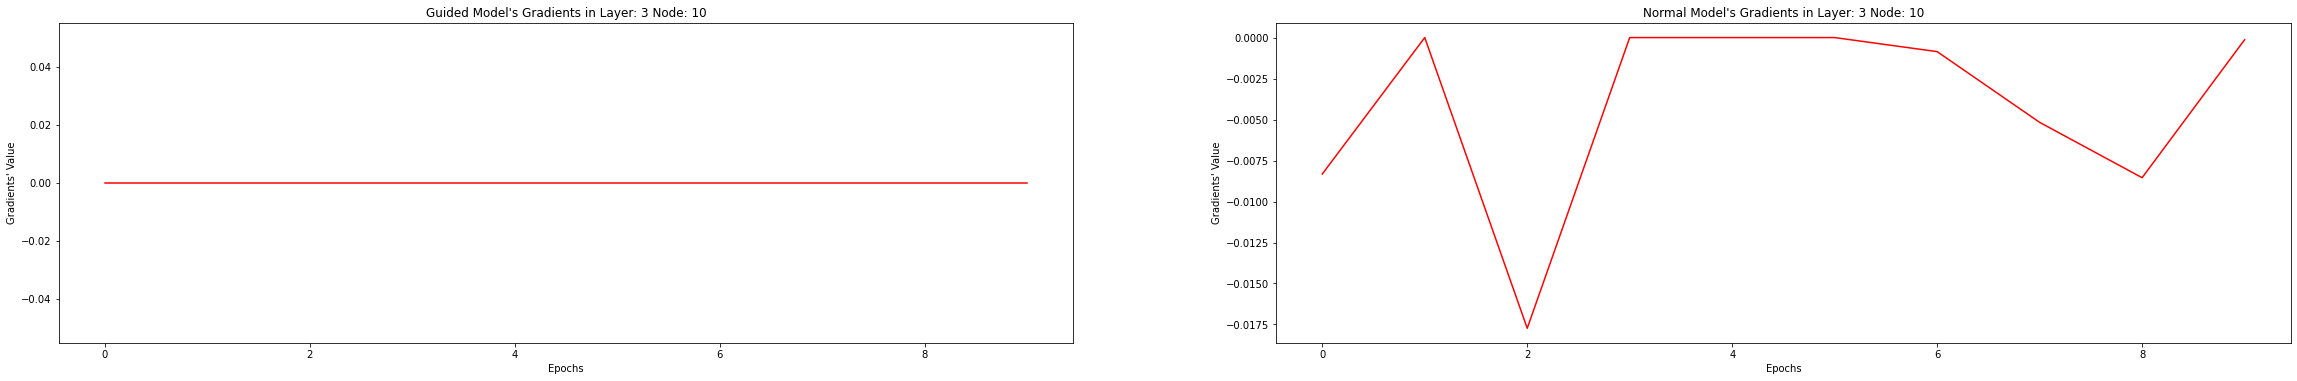

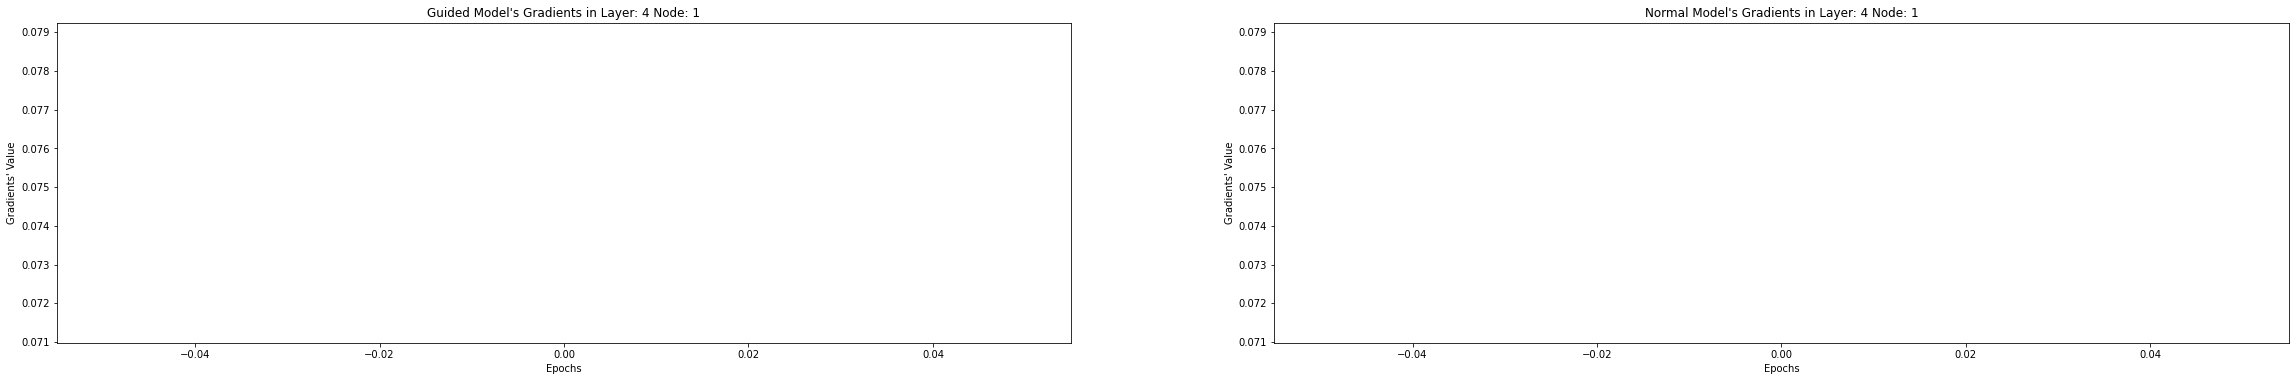

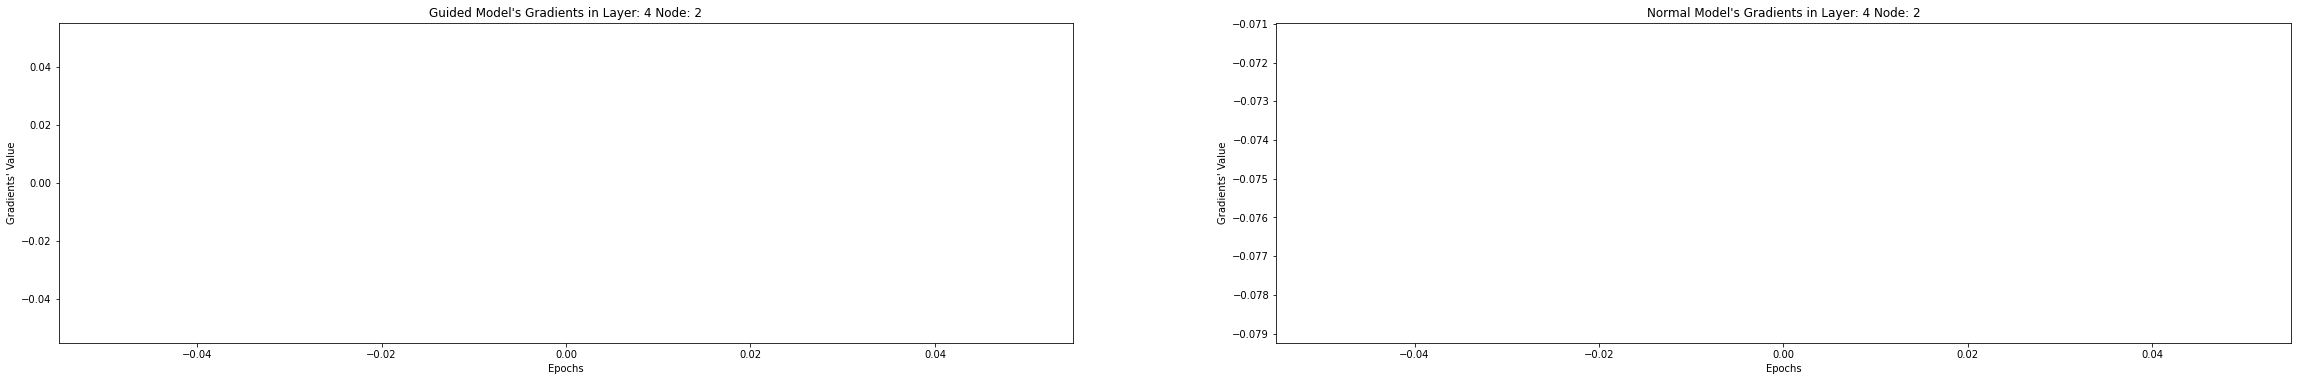

In [ ]:
guided_model_gradients_of_hidden_nodes(holder_of_new_gradients, holder_of_old_gradients, EPOCHS)

In [ ]:
print(GuidedBP_model_GCN.conv1)
sd = GuidedBP_model_GCN.state_dict()
print(sd.keys())
whole_weights = sd.items()
#print(whole_weights)

GCNConv(7, 10)
odict_keys(['conv1.bias', 'conv1.lin.weight', 'conv2.bias', 'conv2.lin.weight', 'conv3.bias', 'conv3.lin.weight', 'lin.weight', 'lin.bias'])


In [ ]:
'''def train_step():
  before_guidance = []
  after_guidance = []
  GuidedBP_loss_batch = []
  non_GuidedBP_loss_batch = []


  GuidedBP_model_GCN.train()
  GuidedBP_optimizer.zero_grad()
  for batched_data in train_loader:
    GuidedBP_out = GuidedBP_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)
    GuidedBP_loss = loss_calculations(GuidedBP_out, batched_data.y)
    GuidedBP_loss_batch.append(GuidedBP_loss)
    GuidedBP_loss.backward()
    GuidedBP_optimizer.step()

    batched_before_guidance = []
    batched_after_guidance = []

    for name, param in GuidedBP_model_GCN.named_parameters():

      if name == "conv1.bias":
        batched_before_guidance.append(param.grad.detach().clone())
        param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
        batched_after_guidance.append(param.grad.detach().clone())
      if name == "conv1.lin.weight":
        #print(param.grad.detach().clone())
        batched_before_guidance.append(param.grad.detach().clone())
        param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
        batched_after_guidance.append(param.grad.detach().clone())

      if name == "conv2.bias":
        batched_before_guidance.append(param.grad.detach().clone())
        param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
        batched_after_guidance.append(param.grad.detach().clone())
      if name == "conv2.lin.weight":
        batched_before_guidance.append(param.grad.detach().clone())
        param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
        batched_after_guidance.append(param.grad.detach().clone())

      if name == "conv3.bias":
        batched_before_guidance.append(param.grad.detach().clone())
        param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
        batched_after_guidance.append(param.grad.detach().clone())
      if name == "conv3.lin.weight":
        batched_before_guidance.append(param.grad.detach().clone())
        param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
        batched_after_guidance.append(param.grad.detach().clone())

      if name == "lin.bias":
        batched_before_guidance.append(param.grad.detach().clone())
        param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
        batched_after_guidance.append(param.grad.detach().clone())
      if name == "lin.weight":
        batched_before_guidance.append(param.grad.detach().clone())
        param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
        batched_after_guidance.append(param.grad.detach().clone())
        
    before_guidance.append(batched_before_guidance)
    after_guidance.append(batched_after_guidance)
  #print(len(before_guidance[-1]))
    
  non_GuidedBP_backpropagation_SAME_MODEL(before_guidance)  
  GuidedBP_backpropagation_SAME_MODEL(after_guidance)

  GuidedBP_optimizer.step()
  
  #############################################################



  return torch.mean(torch.tensor(GuidedBP_loss_batch)), torch.mean(torch.tensor(non_GuidedBP_loss_batch))
'''

## **Gradients of Test Samples with respect to each class**

In [31]:
def compute_grad(model, graph, with_respect):
  post_conv1, post_conv2, out_readout, prediction = model(graph.x, graph.edge_index, graph.batch)
  if with_respect == 1 :
    loss = loss_calculations(prediction, graph.y)
    #print(loss)
  elif with_respect == 2:
    loss = loss_calculations(prediction, torch.tensor([0]))
    #print(loss)  
  elif with_respect == 3:
    loss = loss_calculations(prediction, torch.tensor([1]))
    #print(loss)
  return torch.autograd.grad(loss, list(model.parameters()),allow_unused=True)

In [32]:
def remove_nones(sample_grads):
  #print(type(sample_grads[0]))
  sample_grads2 = []
  for item in sample_grads:
    Each_Graph = []
    for item2 in item:
      if item2 != None:
        Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True),requires_grad=True))
      else:
        Each_Graph.append(torch.tensor(0))
    sample_grads2.append(Each_Graph)
    #print("separate                         ")
        #item2 = torch.tensor([0])
  #print(np.shape(sample_grads[0]))
  #print(np.shape(sample_grads2[0]))
  return sample_grads2

In [33]:
def compute_sample_grads(model, test_dataset, with_respect):

  sample_grads = [compute_grad(model, graph, with_respect) for graph in test_dataset]
  #print(np.shape(sample_grads[0]))
  #print(sample_grads[20])
  sample_grads = remove_nones(sample_grads)
  sample_grads = zip(*sample_grads)
  sample_grads = [torch.stack(shards) for shards in sample_grads]
  #sample_grads = [print(shards) for shards in sample_grads]
  return sample_grads

In [35]:
per_sample_grads_wrt_graph_label = compute_sample_grads(GuidedBP_model_GCN, test_dataset, 1)
per_sample_grads_wrt_class_zero = compute_sample_grads(GuidedBP_model_GCN, test_dataset, 2)
per_sample_grads_wrt_class_one = compute_sample_grads(GuidedBP_model_GCN, test_dataset, 3)

<ipython-input-33-6b36ca0c9073>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True),requires_grad=True))


In [36]:
a = torch.randn((2,7))
print(a)
b = torch.zeros_like(a)
print(b)
c = torch.maximum(a, b)
print(c)

tensor([[ 1.7502,  0.2571, -0.0776, -1.0997,  1.3868, -1.2307,  0.3049],
        [ 0.0896, -1.3245,  0.2679, -2.0401,  1.0435, -0.5663, -1.2502]])
tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]])
tensor([[1.7502, 0.2571, 0.0000, 0.0000, 1.3868, 0.0000, 0.3049],
        [0.0896, 0.0000, 0.2679, 0.0000, 1.0435, 0.0000, 0.0000]])


In [34]:
def compute_guided_gradients(your_model, dataset):
  per_sample_grads_wrt_graph_label = compute_sample_grads(your_model, dataset, 1)
  per_sample_grads_wrt_class_zero = compute_sample_grads(your_model, dataset, 2)
  per_sample_grads_wrt_class_one = compute_sample_grads(your_model, dataset, 3)

  grads_wrt_graph_label = per_sample_grads_wrt_graph_label[0]
  guided_grads_wrt_graph_label = torch.maximum(torch.zeros_like(grads_wrt_graph_label), grads_wrt_graph_label)
  guided_grads_wrt_graph_label = guided_grads_wrt_graph_label.detach().tolist()

  grads_wrt_class_zero = per_sample_grads_wrt_class_zero[0]
  guided_grads_wrt_class_zero = torch.maximum(torch.zeros_like(grads_wrt_class_zero), grads_wrt_class_zero)
  guided_grads_wrt_class_zero = guided_grads_wrt_class_zero.detach().tolist()

  grads_wrt_class_one = per_sample_grads_wrt_class_one[0]
  guided_grads_wrt_class_one = torch.maximum(torch.zeros_like(grads_wrt_class_one), grads_wrt_class_one)
  guided_grads_wrt_class_one = guided_grads_wrt_class_one.detach().tolist()

  return guided_grads_wrt_graph_label, guided_grads_wrt_class_zero, guided_grads_wrt_class_one

In [52]:
guided_grads_wrt_graph_label, guided_grads_wrt_class_zero, guided_grads_wrt_class_one = compute_guided_gradients(GuidedBP_model_GCN, test_dataset)

<ipython-input-33-6b36ca0c9073>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True),requires_grad=True))


## **Fidelity**

In [47]:

def Compute_ROC_AUC(your_model, your_dataset):
  preds = []
  reals = []
  #print(len(your_dataset))
  num_classes = 2
  
  if num_classes > 2:
    print("Fidelity is only for Binaryclassification")
    return 0
    
  your_model.eval()
  for batched_data in your_dataset:
    post_conv1, post_conv2, out_readout, GuidedBP_test_out = your_model(batched_data.x, batched_data.edge_index, batched_data.batch)
    logits = F.log_softmax(GuidedBP_test_out, dim=1)
    prob = F.softmax(logits, dim=1)
    
    preds.append(prob.cpu().detach())
    
  for i in range(len(your_dataset)):
    reals.append(your_dataset[i].y.cpu().detach().tolist())  
  preds = torch.cat(preds).cpu().numpy()
  preds = preds[:, 1]

  
  roc_auc = metrics.roc_auc_score(reals, preds, average='macro')
  return roc_auc
  
  #return preds, reals

In [48]:
def saliency(dataset, gradients):
  Final= []
  for i in range(len(dataset)):
    Mid = []
    for node in dataset[i].x.detach().numpy():
      First = []
      for grad_list in gradients[i]:
        First.append(np.multiply(node, grad_list))
      Mid.append(First)
    Final.append(Mid)
  
  Saliency_Nodes = []
  for graph in Final:
    Node = []
    for node in graph:
      Grad = []
      for grad in node:
        Grad.append(sum(grad))
      Node.append(sum(Grad))
    #norm = [(float(i)-min(Node))/(max(Node)-min(Node)) for i in Node]
    norm = [(float(i))/(max(Node) + 1e-16) for i in Node]
    Saliency_Nodes.append(norm)
  return Saliency_Nodes

In [49]:
def is_salient(score, importance_range):
	start, end = importance_range
	if start <= score <= end:
		return True
	else:
		return False

In [50]:
def drop_important_nodes(your_dataset, importance_range, grads_first_layer):
  GuidedBP_attribution_scores = saliency(your_dataset, grads_first_layer)
  occluded_GNNgraph_list = []
  
  for i in range(len(GuidedBP_attribution_scores)):
    sample_graph = deepcopy(your_dataset[i])
    for j in range(len(sample_graph.x)):
      
      if is_salient((GuidedBP_attribution_scores[i][j]), importance_range):
        #print("before: ", sample_graph.x[j])
        sample_graph.x[j][:] = 0
        #print(torch.zeros_like(sample_graph.x[j]))
        #print("manipulated: ",sample_graph.x[j])
    occluded_GNNgraph_list.append(sample_graph)
  return occluded_GNNgraph_list

In [51]:
def Fidelity(your_model, your_dataset, grads_first_layer, importance_range):

  auc_roc_before_droping_important_nodes = Compute_ROC_AUC(your_model, your_dataset)
  new_graph_dataset = drop_important_nodes(your_dataset, importance_range, grads_first_layer)
  auc_roc_after_droping_important_nodes = Compute_ROC_AUC(your_model, new_graph_dataset)

  return auc_roc_after_droping_important_nodes - auc_roc_before_droping_important_nodes

## **Contrastivity**

In [52]:
def binarize_scores(your_dataset, grads_first_layer, importance_range):
  GuidedBP_attribution_scores = saliency(your_dataset, grads_first_layer)
  binarized_attribution_scores_list = []
  for scores in GuidedBP_attribution_scores:
    binary_score = ''
    for score in scores:
      if is_salient(abs(float(score)), importance_range):
        binary_score += '1'
      else:
        binary_score += '0'
    binarized_attribution_scores_list.append(binary_score)
  return binarized_attribution_scores_list

In [53]:
def compute_contrastivity(your_dataset, your_grads_class0, your_grads_class1, importance_range):
  binarized_salient_nodes_for_class0 = binarize_scores(your_dataset, your_grads_class0, importance_range)
  binarized_salient_nodes_for_class1 = binarize_scores(your_dataset, your_grads_class1, importance_range)

  result_list = []
	# Calculate hamming distance
  for class_0, class_1 in zip(binarized_salient_nodes_for_class0, binarized_salient_nodes_for_class1):
    assert len(class_0) == len(class_1)
    d = hamming(class_0, class_1)
    result_list.append(d / len(class_0))
    
  return sum(result_list) / len(result_list)


## **Sparsity**

In [54]:
def binarize_nodes(your_dataset, your_grads_graph, your_grads_class0, your_grads_class1, importance_range):
  Guided_attribution_scores_class0 = saliency(your_dataset, your_grads_class0)
  Guided_attribution_scores_class1 = saliency(your_dataset, your_grads_class1)
  Guided_attribution_scores_graph = saliency(your_dataset, your_grads_graph)

  class_0_salient_nodes = []
  class_1_salient_nodes = []
  salient_nodes_graph = []
  
  for i in range(len(Guided_attribution_scores_class0)):
      class_0_graph = []
      for j in range(len(Guided_attribution_scores_class0[i])):
        if is_salient((Guided_attribution_scores_class0[i][j]), importance_range):
          class_0_graph.append(1)
        else:
          class_0_graph.append(0)
      class_0_salient_nodes.append(class_0_graph)

  for i in range(len(Guided_attribution_scores_class1)):
      class_1_graph = []
      for j in range(len(Guided_attribution_scores_class1[i])):
        if is_salient((Guided_attribution_scores_class1[i][j]), importance_range):
          class_1_graph.append(1)
        else:
          class_1_graph.append(0)
      class_1_salient_nodes.append(class_1_graph)

  for i in range(len(Guided_attribution_scores_graph)):
      class_graph = []
      for j in range(len(Guided_attribution_scores_graph[i])):
        if is_salient((Guided_attribution_scores_graph[i][j]), importance_range):
          class_graph.append(1)
        else:
          class_graph.append(0)
      salient_nodes_graph.append(class_graph)

  return salient_nodes_graph, class_0_salient_nodes, class_1_salient_nodes

In [55]:
def count_important_nodes(salient_list):
  return sum(salient_list)

In [56]:
def compute_sparsity(your_dataset, your_grads_graph, your_grads_class0, your_grads_class1, importance_range):
  salient_nodes_graph, class_0_salient_nodes, class_1_salient_nodes = binarize_nodes(your_dataset, your_grads_graph, your_grads_class0, your_grads_class1, importance_range)
  #print(salient_nodes_graph)
  #print(class_0_salient_nodes)
  #print(class_1_salient_nodes)
  sparsity_list = []
  for i in range(len(salient_nodes_graph)):
    d = count_important_nodes(class_0_salient_nodes[i]) + count_important_nodes(class_1_salient_nodes[i])
    d = d / (len(salient_nodes_graph) * 2)
    sparsity_list.append(1 - d)
  return sum(sparsity_list) / len(sparsity_list)

## **Get Metrics**

In [57]:
def go_to_evaluations(your_model, dataset, importance_range):
  start_generation = perf_counter()
  guided_grads_wrt_graph_label, guided_grads_wrt_class_zero, guided_grads_wrt_class_one = compute_guided_gradients(your_model, dataset)
  time_consumption = perf_counter() - start_generation

  fid_guided_glabel = Fidelity(your_model, dataset, guided_grads_wrt_graph_label, importance_range)

  contrastivity_with_guided = compute_contrastivity(dataset, guided_grads_wrt_class_zero, guided_grads_wrt_class_one, importance_range)

  sparsity_with_guided = compute_sparsity(dataset, guided_grads_wrt_graph_label, guided_grads_wrt_class_zero, guided_grads_wrt_class_one, importance_range)


  #.         ["Explicability Method Name", "DataSet", "Fidelity", "Contrastivity", "Sparsity", "Saliency Map Generation Time"]
  #with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons ExMethods.csv", 'a') as outcsv:
   # wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    #wr.writerow([str(Explainability_name), "MUTAG", fid_guided_glabel, contrastivity_with_guided, sparsity_with_guided, time_consumption])
  task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
  with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons ExMethods for SoftWare.csv", 'a') as outcsv:
    wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    wr.writerow([str(Explainability_name), task_dict[str(Task_name)], "MUTAG", "GCN+GAP", Auc_Roc, Auc_Prc, GuidedBP_Model_training_Acc_per_epoch[-1], Acc, Acc2, fid_guided_glabel, contrastivity_with_guided, sparsity_with_guided, time_consumption, mean(GuidedBP_Model_training_time_per_epoch), times])


  #return fid_square_glabel, contrastivity_with_square, sparsity_with_square, time_consumption

In [58]:
go_to_evaluations(GuidedBP_model_GCN, test_dataset, (0.5, 1))

<ipython-input-32-6b36ca0c9073>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True),requires_grad=True))
